Import Libraries and Define Core Functions

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec

def generate_traffic_demand(demand_scenario, total_timesteps, link_indices_with_onramps, high_demand_val, low_demand_val, num_links):
    """
    Creates a demand matrix (num_links, total_timesteps) for highway on-ramp sections.
    Demand is zero for mainline sections.
    If low_demand_val is None, default low values are applied:
    - 50 for link index 11
    - 100 for other on-ramp link indices.
    """
    flow_req = np.zeros((num_links, total_timesteps))

    if low_demand_val is None:
        low_val_map = {i: (50 if i == 11 else 100) for i in link_indices_with_onramps}
    else:
        low_val_map = {i: low_demand_val for i in link_indices_with_onramps}

    if demand_scenario == "baseline":
        for k in range(100):
            for i in link_indices_with_onramps:
                flow_req[i, k] = high_demand_val
        for k in range(100, total_timesteps):
            for i in link_indices_with_onramps:
                flow_req[i, k] = low_val_map[i]
    elif demand_scenario == "high_constant":
        for k in range(total_timesteps):
            for i in link_indices_with_onramps:
                flow_req[i, k] = high_demand_val
    elif demand_scenario == "low_constant":
        for k in range(total_timesteps):
            for i in link_indices_with_onramps:
                flow_req[i, k] = low_val_map[i]
    elif demand_scenario == "oscillatory":
        for k in range(total_timesteps):
            current_demand = low_val_map[link_indices_with_onramps[0]] + \
                             (high_demand_val - low_val_map[link_indices_with_onramps[0]]) * \
                             0.5 * (1 + np.sin(2 * np.pi * k / total_timesteps))
            for i in link_indices_with_onramps:
                flow_req[i, k] = current_demand
    elif demand_scenario == "step_change":
        for k in range(total_timesteps):
            for i in link_indices_with_onramps:
                if k < total_timesteps // 2:
                    flow_req[i, k] = low_val_map[i]
                else:
                    flow_req[i, k] = high_demand_val
    elif demand_scenario == "random":
        for k in range(100):
            for i in link_indices_with_onramps:
                base_val = high_demand_val
                noise_val = np.random.normal(0, 100)
                flow_req[i, k] = max(0, base_val + noise_val)
        for k in range(100, total_timesteps):
            for i in link_indices_with_onramps:
                base_val = low_val_map[i]
                noise_val = np.random.normal(0, 50)
                flow_req[i, k] = max(0, base_val + noise_val)
    else: # Default to baseline
        for k in range(100):
            for i in link_indices_with_onramps:
                flow_req[i, k] = high_demand_val
        for k in range(100, total_timesteps):
            for i in link_indices_with_onramps:
                flow_req[i, k] = low_val_map[i]
    return flow_req


def run_traffic_simulation(num_links, total_timesteps, time_step, link_lengths, max_density,
                           free_flow_speed, congestion_wave_speed, initial_density,
                           initial_flow, entry_density, entry_flow, exit_density, exit_flow,
                           demand_matrix, onramp_indicators, alinea_gain, target_density,
                           max_metering_rate, min_metering_rate):
    """
    Executes simulations for both an uncontrolled scenario (open-loop) and a controlled
    scenario using a modified ALINEA logic (closed-loop) with downstream density feedback.

    Returns a dictionary containing simulation results for both cases:
      - "uncontrolled": { "densities": density_unc, "flows": flow_unc, "ramp_flows": ramp_unc }
      - "controlled":   { "densities": density_ctrl, "flows": flow_ctrl, "ramp_flows": ramp_ctrl }
    """

    # --- Uncontrolled Simulation ---
    density_unc = np.zeros((num_links, total_timesteps + 1))
    flow_unc = np.zeros((num_links, total_timesteps))
    ramp_unc = demand_matrix.copy()  # On-ramp flows follow demand without control.

    density_unc[:, 0] = initial_density[:]
    density_unc[:, 0] = np.clip(density_unc[:, 0], 0, max_density)

    for k in range(total_timesteps):
        # Calculate flows using CTM
        flow_unc[0, k] = min(entry_flow[k], congestion_wave_speed[0] * (max_density[0] - density_unc[0, k]) - ramp_unc[0, k])
        flow_unc[0, k] = max(0, flow_unc[0, k]) # Ensure non-negative flow
        for i in range(1, num_links):
            flow_unc[i, k] = min(free_flow_speed[i - 1] * density_unc[i - 1, k],
                                 congestion_wave_speed[i] * (max_density[i] - density_unc[i, k]) - ramp_unc[i, k])
            flow_unc[i, k] = max(0, flow_unc[i, k]) # Ensure non-negative flow

        # Update densities using CTM
        for i in range(num_links - 1):
            density_unc[i, k + 1] = density_unc[i, k] + time_step / link_lengths[i] * (flow_unc[i, k] + ramp_unc[i, k] - flow_unc[i + 1, k])

        # Handle last link's outflow
        current_outflow_unc = min(free_flow_speed[num_links - 1] * density_unc[num_links - 1, k], exit_flow[k])
        density_unc[num_links - 1, k + 1] = density_unc[num_links - 1, k] + time_step / link_lengths[num_links - 1] * \
                                             (flow_unc[num_links - 1, k] + ramp_unc[num_links - 1, k] - current_outflow_unc)
        density_unc[:, k + 1] = np.clip(density_unc[:, k + 1], 0, max_density) # Enforce bounds

    # --- ALINEA Control Simulation ---
    density_ctrl = np.zeros((num_links, total_timesteps + 1))
    flow_ctrl = np.zeros((num_links, total_timesteps))
    ramp_ctrl = np.zeros((num_links, total_timesteps)) # Initialize controlled ramp flows

    density_ctrl[:, 0] = initial_density[:]

    # Store the previous ALINEA rate for each ramp, initialized to max_metering_rate
    prev_alinea_rate = np.full(num_links, max_metering_rate)

    for k in range(total_timesteps):
        # A. ALINEA Controller Calculation
        for i in range(num_links):
            if onramp_indicators[i] == 1: # If this link has an on-ramp
                if i < num_links - 1: # Check if a downstream link exists
                    # Measure density DOWNSTREAM of the ramp
                    measured_density = density_ctrl[i + 1, k]
                    # Calculate ALINEA desired rate (Integral Control)
                    calculated_rate = prev_alinea_rate[i] + alinea_gain * (target_density - measured_density)
                    # Apply min/max constraints
                    desired_rate = np.clip(calculated_rate, min_metering_rate, max_metering_rate)
                    # Actual ramp flow is the lesser of ALINEA rate and demand
                    ramp_ctrl[i, k] = min(desired_rate, demand_matrix[i, k])
                    # Store this rate for the next iteration's calculation
                    prev_alinea_rate[i] = ramp_ctrl[i, k]
                else: # Handle ramp at the very last link (no downstream)
                    # Fallback: Just use demand, no control possible here with downstream logic
                    ramp_ctrl[i, k] = demand_matrix[i, k]
                    prev_alinea_rate[i] = ramp_ctrl[i, k]
            else:
                ramp_ctrl[i, k] = 0 # No ramp flow for non-ramp links

        # B. CTM Calculation using the ALINEA-controlled ramp flow
        flow_ctrl[0, k] = min(entry_flow[k], congestion_wave_speed[0] * (max_density[0] - density_ctrl[0, k]) - ramp_ctrl[0, k])
        flow_ctrl[0, k] = max(0, flow_ctrl[0, k]) # Ensure non-negative flow
        for i in range(1, num_links):
            flow_ctrl[i, k] = min(free_flow_speed[i - 1] * density_ctrl[i - 1, k],
                                 congestion_wave_speed[i] * (max_density[i] - density_ctrl[i, k]) - ramp_ctrl[i, k])
            flow_ctrl[i, k] = max(0, flow_ctrl[i, k]) # Ensure non-negative flow

        # Update densities
        for i in range(num_links - 1):
            density_ctrl[i, k + 1] = density_ctrl[i, k] + time_step / link_lengths[i] * (flow_ctrl[i, k] + ramp_ctrl[i, k] - flow_ctrl[i + 1, k])

        # Handle last link's outflow
        current_outflow_ctrl = min(free_flow_speed[num_links - 1] * density_ctrl[num_links - 1, k], exit_flow[k])
        density_ctrl[num_links - 1, k + 1] = density_ctrl[num_links - 1, k] + time_step / link_lengths[num_links - 1] * \
                                              (flow_ctrl[num_links - 1, k] + ramp_ctrl[num_links - 1, k] - current_outflow_ctrl)
        density_ctrl[:, k + 1] = np.clip(density_ctrl[:, k + 1], 0, max_density) # Enforce bounds

    return {"uncontrolled": {"densities": density_unc, "flows": flow_unc, "ramp_flows": ramp_unc},
            "controlled":   {"densities": density_ctrl, "flows": flow_ctrl, "ramp_flows": ramp_ctrl}}

Define Simulation Parameters and Scenarios

In [ ]:
# Global simulation parameters
NUM_LINKS = 20           # Number of highway sections
TOTAL_TIMESTEPS = 360 * 2  # 2 hours simulation with 10-second sampling
TIME_STEP_HRS = 10 / 3600  # 10 seconds converted to hours
LINK_LENGTHS_KM = np.full(NUM_LINKS, 0.5) # Section lengths in kilometers
CONGESTION_WAVE_SPEED_KMPH = np.full(NUM_LINKS, 27) # Congested wave speed in km/h

# Boundary conditions for the first and last sections
DEFAULT_ENTRY_DENSITY = 60
DEFAULT_EXIT_DENSITY = 80
entry_density_profile = np.full(TOTAL_TIMESTEPS, DEFAULT_ENTRY_DENSITY)
# Assuming a free-flow speed of 100 for boundary flow calculation
entry_flow_profile = entry_density_profile * 100
exit_density_profile = np.full(TOTAL_TIMESTEPS, DEFAULT_EXIT_DENSITY)
exit_flow_profile = exit_density_profile * 100

# Controller parameters (for the ALINEA-like control)
CONTROLLER_GAIN = 70       # Controller gain value
TARGET_DENSITY = 60        # Target mainline density (veh/km) - comparable to critical density
MAX_METERING_RATE = 2000   # Maximum allowed ramp metering rate (veh/h)
MIN_METERING_RATE = 100    # Minimum allowed ramp metering rate (veh/h)

# Traffic Scenarios
simulation_scenarios = [
    {"name": "Standard Traffic Pattern",
     "demand_type": "baseline",
     "onramp_link_indices": [4, 9, 11],
     "peak_demand_value": 2000,
     "offpeak_demand_value": None,
     "initial_link_density": 60,
     "link_free_flow_speed": 100,
     "link_max_density": 300},

    {"name": "Persistent High Demand",
     "demand_type": "high_constant",
     "onramp_link_indices": [4, 9, 11],
     "peak_demand_value": 2000,
     "offpeak_demand_value": 2000,
     "initial_link_density": 60,
     "link_free_flow_speed": 100,
     "link_max_density": 300},

    {"name": "Fluctuating Demand",
     "demand_type": "oscillatory",
     "onramp_link_indices": [4, 9, 11],
     "peak_demand_value": 2000,
     "offpeak_demand_value": 100,
     "initial_link_density": 60,
     "link_free_flow_speed": 100,
     "link_max_density": 300},
]

Execute Simulations

In [ ]:
# --- SIMULATION EXECUTION LOOP ---

simulation_results = {}

for scenario in simulation_scenarios:
    print(f"--- Initiating Scenario: {scenario['name']} ---")

    # Set up scenario-specific initial and boundary conditions
    initial_density_val = scenario.get("initial_link_density", 60)
    current_initial_density = np.full(NUM_LINKS, initial_density_val)

    link_free_flow_speed_val = scenario.get("link_free_flow_speed", 100)
    # Estimate initial flow (assuming free flow initially)
    current_initial_flow = current_initial_density * link_free_flow_speed_val

    entry_density_val = scenario.get("entry_density", DEFAULT_ENTRY_DENSITY)
    exit_density_val = scenario.get("exit_density", DEFAULT_EXIT_DENSITY)

    current_entry_density_profile = np.full(TOTAL_TIMESTEPS, entry_density_val)
    current_entry_flow_profile = current_entry_density_profile * link_free_flow_speed_val
    current_exit_density_profile = np.full(TOTAL_TIMESTEPS, exit_density_val)
    current_exit_flow_profile = current_exit_density_profile * link_free_flow_speed_val

    free_flow_speed_arr = np.full(NUM_LINKS, link_free_flow_speed_val)
    max_density_val = scenario.get("link_max_density", 300)
    max_density_arr = np.full(NUM_LINKS, max_density_val)

    onramp_link_indices = scenario["onramp_link_indices"]
    # Create an indicator array for on-ramp links
    onramp_indicator_arr = np.zeros(NUM_LINKS)
    for idx in onramp_link_indices:
        onramp_indicator_arr[idx] = 1

    # Generate traffic demand for the current scenario
    current_demand_matrix = generate_traffic_demand(
        demand_scenario=scenario["demand_type"],
        total_timesteps=TOTAL_TIMESTEPS,
        link_indices_with_onramps=onramp_link_indices,
        high_demand_val=scenario["peak_demand_value"],
        low_demand_val=scenario["offpeak_demand_value"],
        num_links=NUM_LINKS
    )

    # Run the simulations for the current scenario
    scenario_output = run_traffic_simulation(
        NUM_LINKS, TOTAL_TIMESTEPS, TIME_STEP_HRS, LINK_LENGTHS_KM, max_density_arr,
        free_flow_speed_arr, CONGESTION_WAVE_SPEED_KMPH, current_initial_density,
        current_initial_flow, current_entry_density_profile, current_entry_flow_profile,
        current_exit_density_profile, current_exit_flow_profile, current_demand_matrix,
        onramp_indicator_arr, CONTROLLER_GAIN, TARGET_DENSITY,
        MAX_METERING_RATE, MIN_METERING_RATE
    )
    simulation_results[scenario['name']] = scenario_output
    simulation_results[scenario['name']]['original_demand'] = current_demand_matrix
    simulation_results[scenario['name']]['onramp_indices'] = onramp_link_indices
    simulation_results[scenario['name']]['target_density'] = TARGET_DENSITY
    print(f"--- Scenario '{scenario['name']}' Completed ---")

print('\nAll Simulations Concluded.')

--- Initiating Scenario: Standard Traffic Pattern ---
--- Scenario 'Standard Traffic Pattern' Completed ---
--- Initiating Scenario: Persistent High Demand ---
--- Scenario 'Persistent High Demand' Completed ---
--- Initiating Scenario: Fluctuating Demand ---
--- Scenario 'Fluctuating Demand' Completed ---

All Simulations Concluded.


Plotting Results


--- Generating Plots for All Scenarios ---
Plotting for Scenario: Standard Traffic Pattern


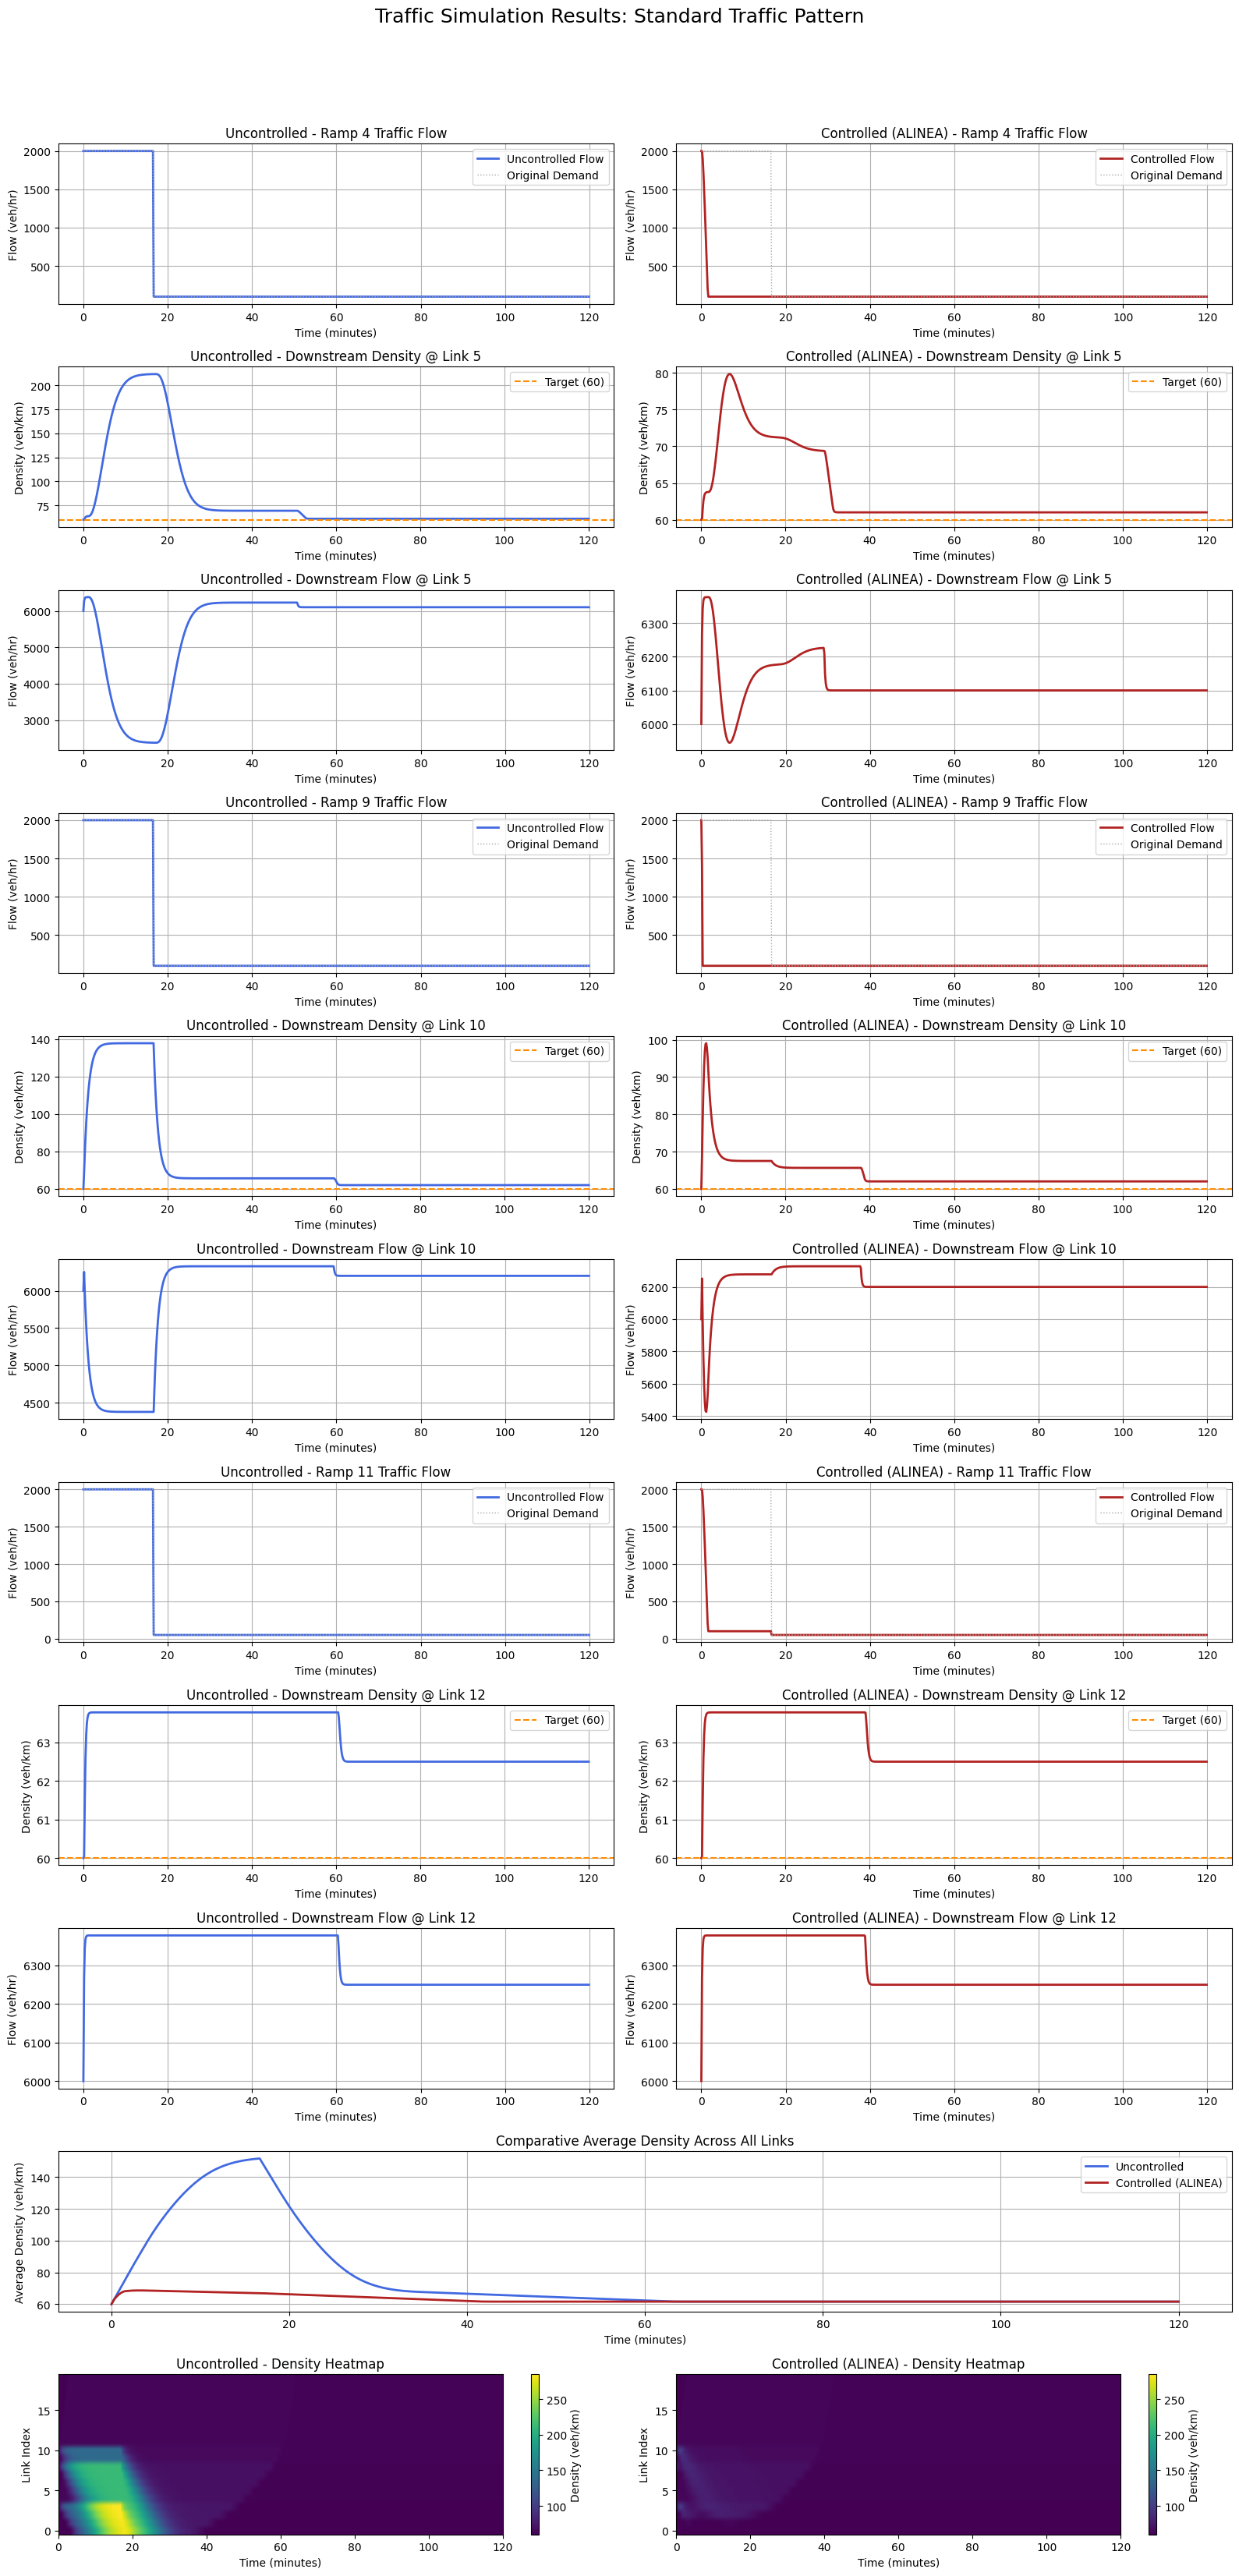

Plotting for Scenario: Persistent High Demand


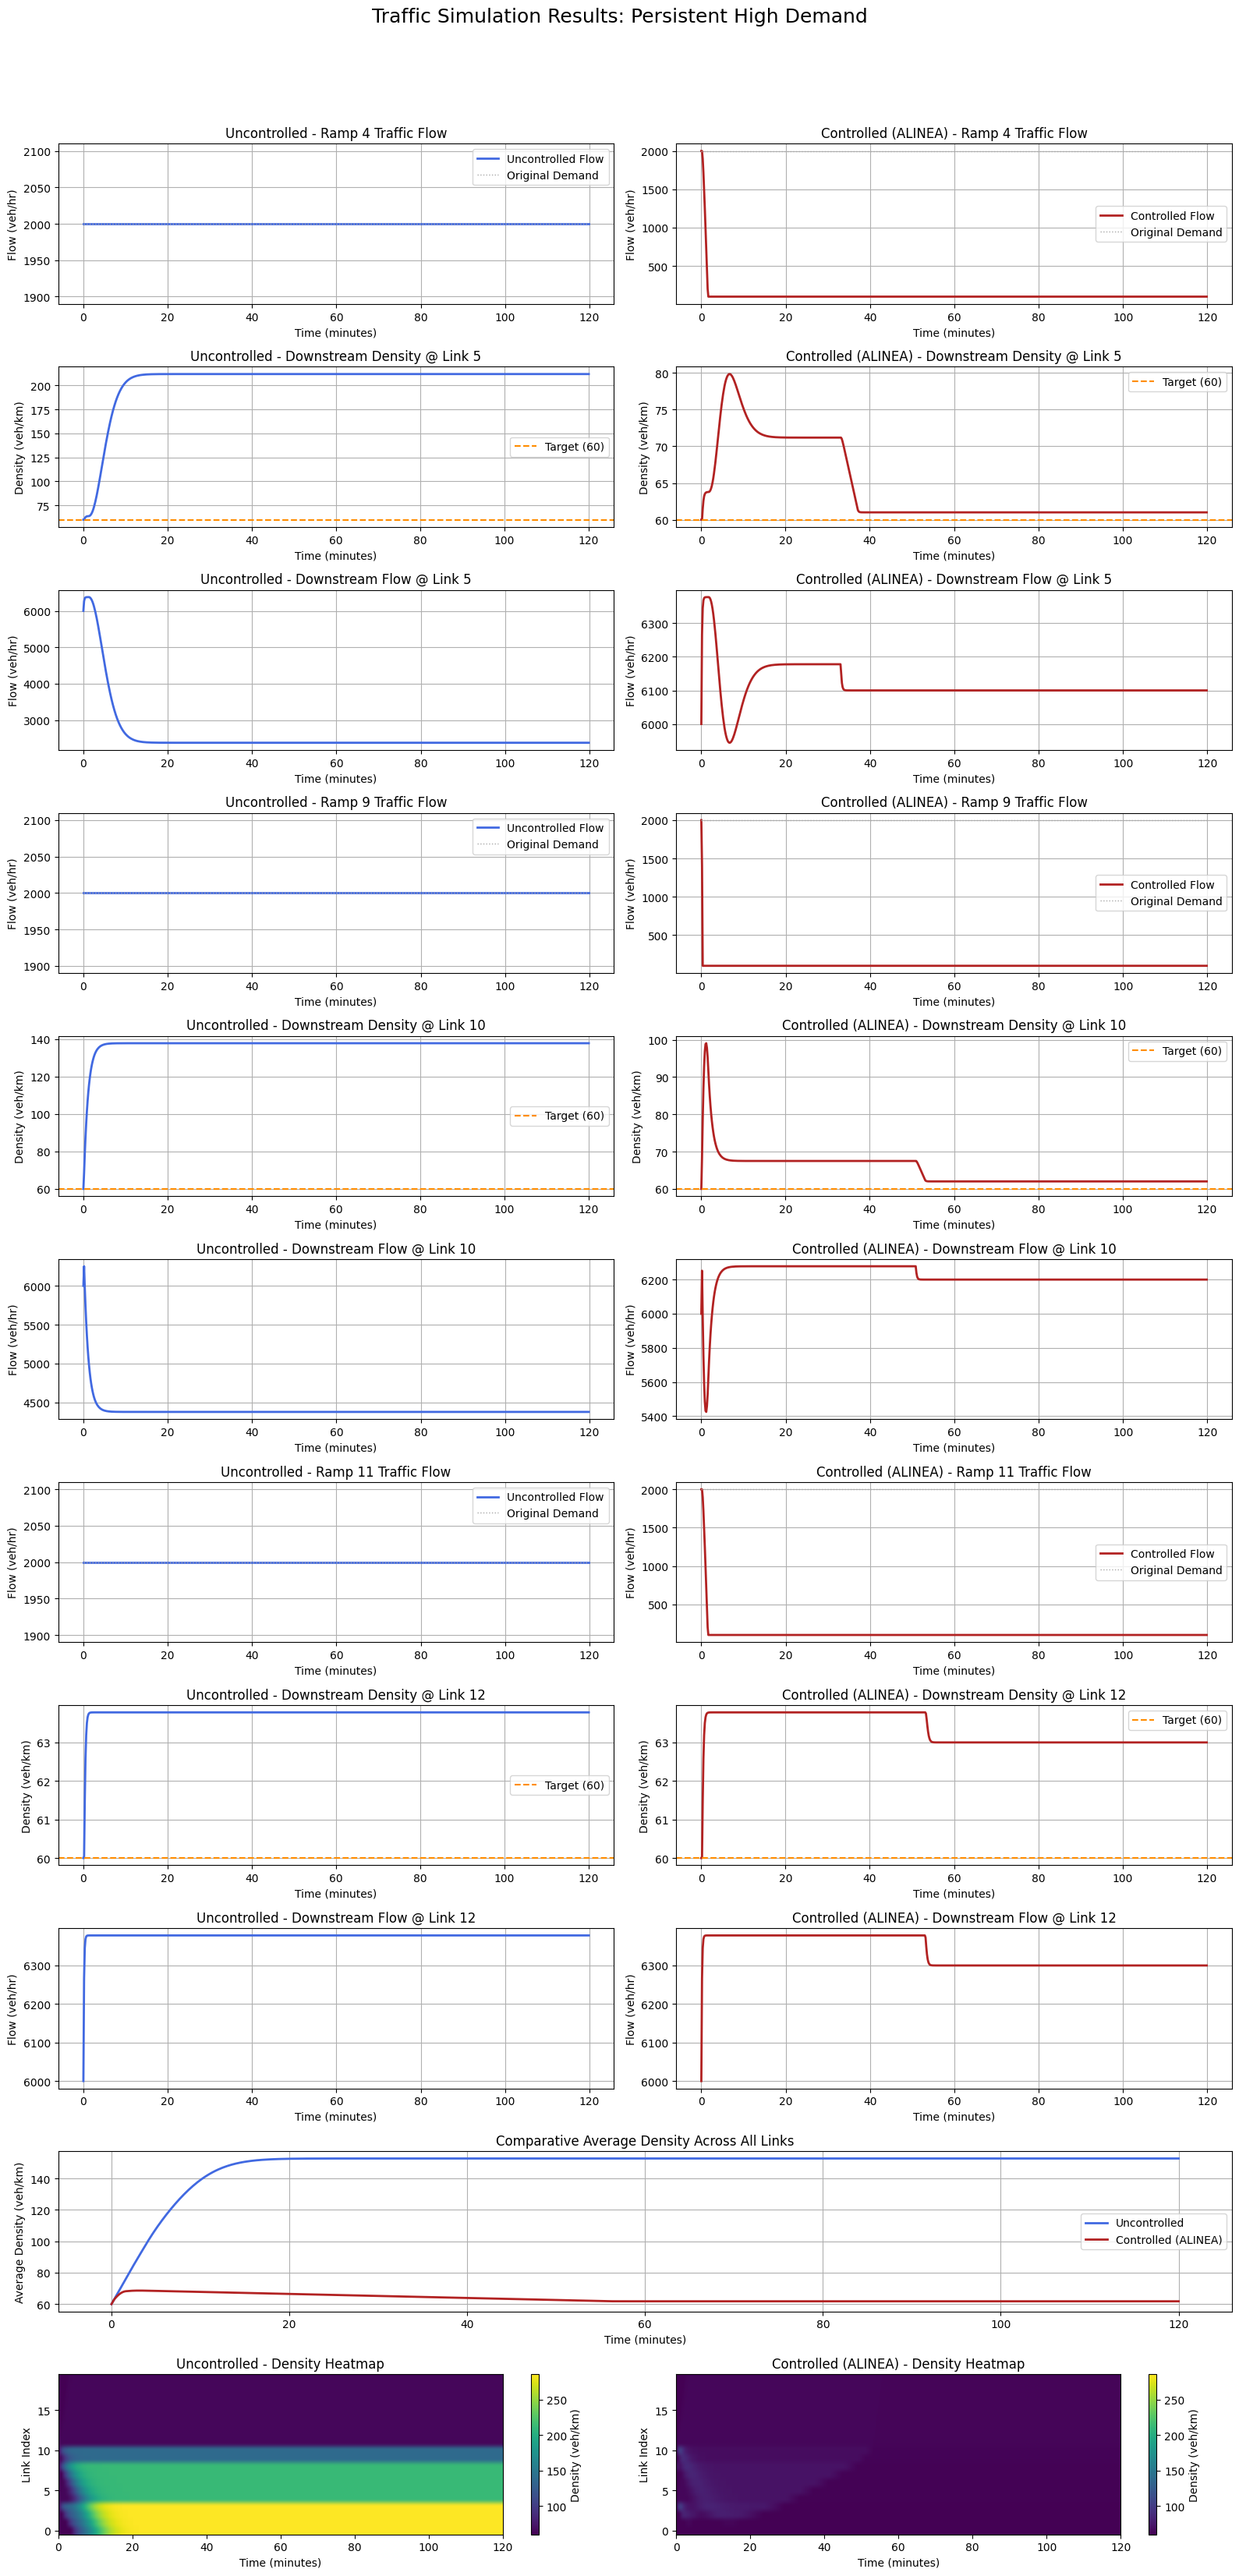

Plotting for Scenario: Fluctuating Demand


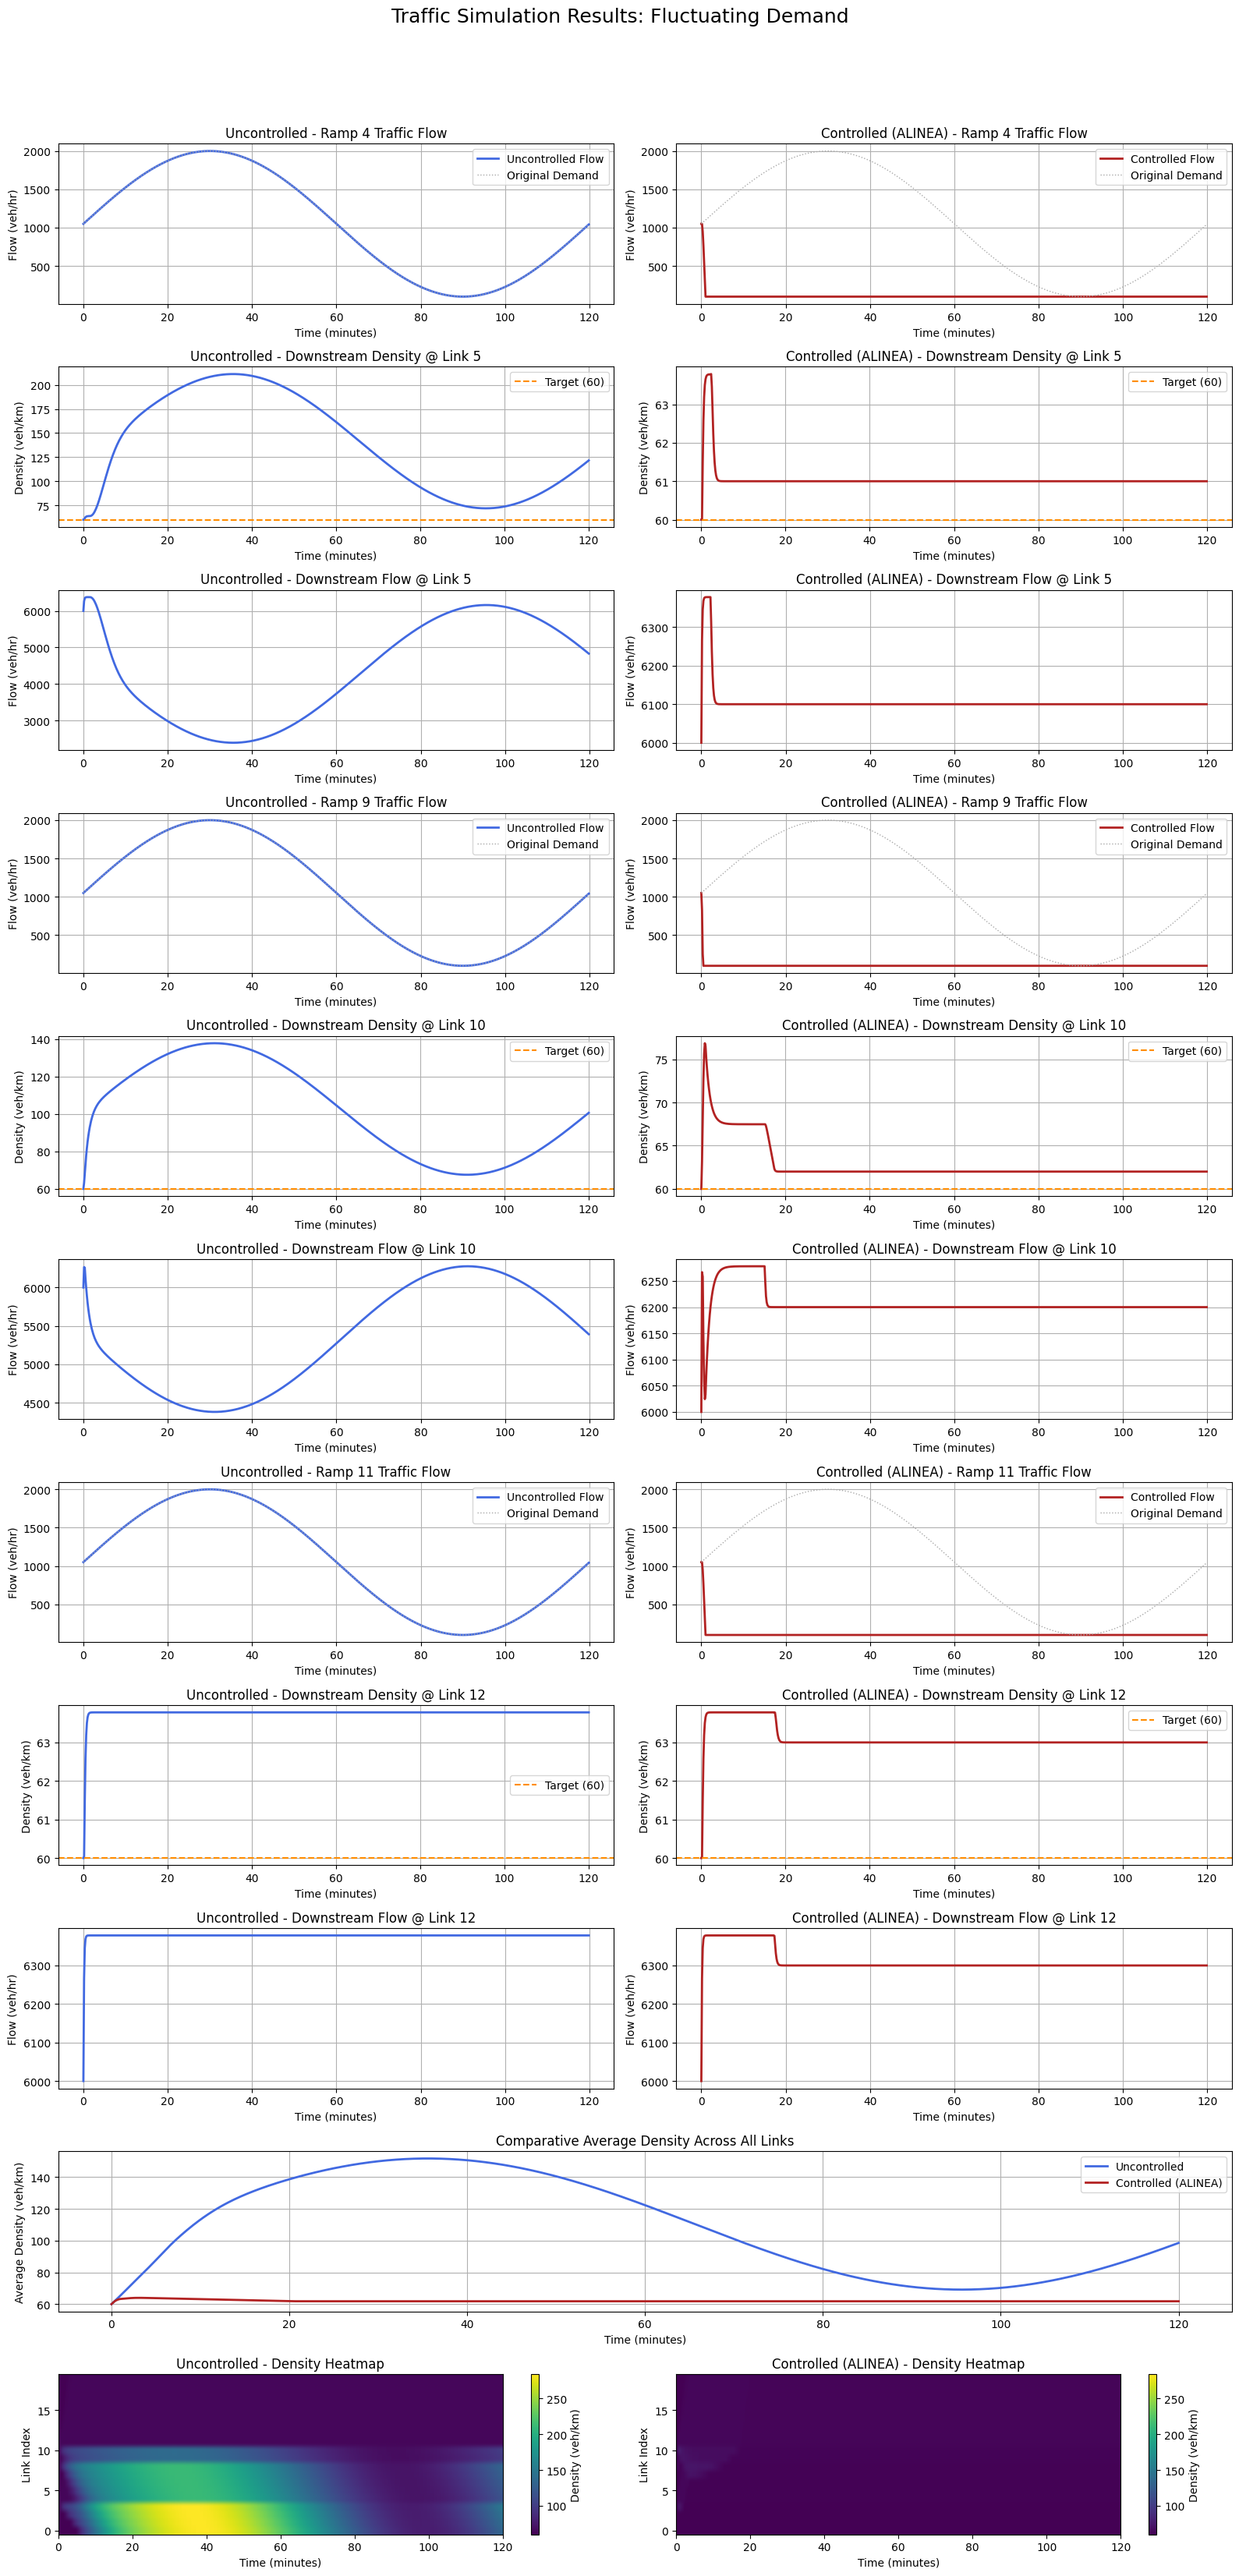

--- All Plotting Complete ---


In [ ]:
# --- PLOTTING RESULTS ---

print("\n--- Generating Plots for All Scenarios ---")

for scenario_name, results_data in simulation_results.items():
    print(f"Plotting for Scenario: {scenario_name}")

    uncontrolled_data = results_data["uncontrolled"]
    controlled_data = results_data["controlled"]
    original_demand_data = results_data["original_demand"]
    ramp_section_indices = results_data["onramp_indices"]
    plot_target_density = results_data["target_density"]

    num_ramps_to_plot = len(ramp_section_indices)
    total_plot_rows = 3 * num_ramps_to_plot + 2 # 3 plots per ramp + 1 for overall avg + 1 for heatmaps

    fig = plt.figure(figsize=(16, 3 * total_plot_rows))
    gs = gridspec.GridSpec(total_plot_rows, 2, figure=fig)

    time_flow_plots = np.arange(TOTAL_TIMESTEPS) * TIME_STEP_HRS * 60     # Time in minutes for K steps
    time_density_plots = np.arange(TOTAL_TIMESTEPS + 1) * TIME_STEP_HRS * 60 # Time in minutes for K+1 steps

    # Loop over each on-ramp section
    for j, current_ramp_idx in enumerate(ramp_section_indices):
        # Determine the downstream section for plotting (must be within bounds)
        downstream_plot_idx = current_ramp_idx + 1 if current_ramp_idx < NUM_LINKS - 1 else current_ramp_idx

        # --- Uncontrolled Column Plots ---
        ax_ramp_flow_unc = fig.add_subplot(gs[3*j, 0])
        ax_ramp_flow_unc.plot(time_flow_plots, uncontrolled_data["ramp_flows"][current_ramp_idx, :], color='royalblue', linewidth=2, label='Uncontrolled Flow')
        ax_ramp_flow_unc.plot(time_flow_plots, original_demand_data[current_ramp_idx, :], color='darkgray', linestyle=':', linewidth=1, label='Original Demand')
        ax_ramp_flow_unc.set_title(f'Uncontrolled - Ramp {current_ramp_idx} Traffic Flow')
        ax_ramp_flow_unc.set_xlabel('Time (minutes)')
        ax_ramp_flow_unc.set_ylabel('Flow (veh/hr)')
        ax_ramp_flow_unc.legend()
        ax_ramp_flow_unc.grid(True)

        ax_down_density_unc = fig.add_subplot(gs[3*j + 1, 0])
        ax_down_density_unc.plot(time_density_plots, uncontrolled_data["densities"][downstream_plot_idx, :], color='royalblue', linewidth=2)
        ax_down_density_unc.axhline(y=plot_target_density, color='darkorange', linestyle='--', label=f'Target ({plot_target_density})')
        ax_down_density_unc.set_title(f'Uncontrolled - Downstream Density @ Link {downstream_plot_idx}')
        ax_down_density_unc.set_xlabel('Time (minutes)')
        ax_down_density_unc.set_ylabel('Density (veh/km)')
        ax_down_density_unc.legend()
        ax_down_density_unc.grid(True)

        ax_down_flow_unc = fig.add_subplot(gs[3*j + 2, 0])
        if current_ramp_idx < NUM_LINKS - 1:
            downstream_flow_unc = uncontrolled_data["flows"][current_ramp_idx + 1, :]
        else: # For the very last link, its outflow is its mainline flow constrained by exit capacity
            downstream_flow_unc = np.minimum(free_flow_speed_arr[-1] * uncontrolled_data["densities"][current_ramp_idx, :TOTAL_TIMESTEPS], exit_flow_profile)
        ax_down_flow_unc.plot(time_flow_plots, downstream_flow_unc, color='royalblue', linewidth=2)
        ax_down_flow_unc.set_title(f'Uncontrolled - Downstream Flow @ Link {downstream_plot_idx}')
        ax_down_flow_unc.set_xlabel('Time (minutes)')
        ax_down_flow_unc.set_ylabel('Flow (veh/hr)')
        ax_down_flow_unc.grid(True)

        # --- ALINEA Controlled Column Plots ---
        ax_ramp_flow_ctrl = fig.add_subplot(gs[3*j, 1])
        ax_ramp_flow_ctrl.plot(time_flow_plots, controlled_data["ramp_flows"][current_ramp_idx, :], color='firebrick', linewidth=2, label='Controlled Flow')
        ax_ramp_flow_ctrl.plot(time_flow_plots, original_demand_data[current_ramp_idx, :], color='darkgray', linestyle=':', linewidth=1, label='Original Demand')
        ax_ramp_flow_ctrl.set_title(f'Controlled (ALINEA) - Ramp {current_ramp_idx} Traffic Flow')
        ax_ramp_flow_ctrl.set_xlabel('Time (minutes)')
        ax_ramp_flow_ctrl.set_ylabel('Flow (veh/hr)')
        ax_ramp_flow_ctrl.legend()
        ax_ramp_flow_ctrl.grid(True)

        ax_down_density_ctrl = fig.add_subplot(gs[3*j + 1, 1])
        ax_down_density_ctrl.plot(time_density_plots, controlled_data["densities"][downstream_plot_idx, :], color='firebrick', linewidth=2)
        ax_down_density_ctrl.axhline(y=plot_target_density, color='darkorange', linestyle='--', label=f'Target ({plot_target_density})')
        ax_down_density_ctrl.set_title(f'Controlled (ALINEA) - Downstream Density @ Link {downstream_plot_idx}')
        ax_down_density_ctrl.set_xlabel('Time (minutes)')
        ax_down_density_ctrl.set_ylabel('Density (veh/km)')
        ax_down_density_ctrl.legend()
        ax_down_density_ctrl.grid(True)

        ax_down_flow_ctrl = fig.add_subplot(gs[3*j + 2, 1])
        if current_ramp_idx < NUM_LINKS - 1:
            downstream_flow_ctrl = controlled_data["flows"][current_ramp_idx + 1, :]
        else: # For the very last link, its outflow is its mainline flow constrained by exit capacity
            downstream_flow_ctrl = np.minimum(free_flow_speed_arr[-1] * controlled_data["densities"][current_ramp_idx, :TOTAL_TIMESTEPS], exit_flow_profile)
        ax_down_flow_ctrl.plot(time_flow_plots, downstream_flow_ctrl, color='firebrick', linewidth=2)
        ax_down_flow_ctrl.set_title(f'Controlled (ALINEA) - Downstream Flow @ Link {downstream_plot_idx}')
        ax_down_flow_ctrl.set_xlabel('Time (minutes)')
        ax_down_flow_ctrl.set_ylabel('Flow (veh/hr)')
        ax_down_flow_ctrl.grid(True)

    # --- Overall Average Density Comparison ---
    overall_avg_row = 3 * num_ramps_to_plot
    ax_overall_avg = fig.add_subplot(gs[overall_avg_row, :])
    avg_density_unc = np.mean(uncontrolled_data["densities"], axis=0)
    avg_density_ctrl = np.mean(controlled_data["densities"], axis=0)
    ax_overall_avg.plot(time_density_plots, avg_density_unc, color='royalblue', label='Uncontrolled', linewidth=2)
    ax_overall_avg.plot(time_density_plots, avg_density_ctrl, color='firebrick', label='Controlled (ALINEA)', linewidth=2)
    ax_overall_avg.set_title('Comparative Average Density Across All Links')
    ax_overall_avg.set_xlabel('Time (minutes)')
    ax_overall_avg.set_ylabel('Average Density (veh/km)')
    ax_overall_avg.legend()
    ax_overall_avg.grid(True)

    # --- Density Heatmaps ---
    heatmap_row = overall_avg_row + 1
    global_density_min = min(np.min(uncontrolled_data["densities"]), np.min(controlled_data["densities"]))
    global_density_max = max(np.max(uncontrolled_data["densities"]), np.max(controlled_data["densities"]))

    ax_heatmap_unc = fig.add_subplot(gs[heatmap_row, 0])
    im_unc_heatmap = ax_heatmap_unc.imshow(uncontrolled_data["densities"], aspect='auto', origin='lower',
                                           vmin=global_density_min, vmax=global_density_max, cmap='viridis',
                                           extent=[time_density_plots.min(), time_density_plots.max(), -0.5, NUM_LINKS - 0.5])
    ax_heatmap_unc.set_title('Uncontrolled - Density Heatmap')
    ax_heatmap_unc.set_xlabel('Time (minutes)')
    ax_heatmap_unc.set_ylabel('Link Index')
    fig.colorbar(im_unc_heatmap, ax=ax_heatmap_unc, label='Density (veh/km)')

    ax_heatmap_ctrl = fig.add_subplot(gs[heatmap_row, 1])
    im_ctrl_heatmap = ax_heatmap_ctrl.imshow(controlled_data["densities"], aspect='auto', origin='lower',
                                           vmin=global_density_min, vmax=global_density_max, cmap='viridis',
                                           extent=[time_density_plots.min(), time_density_plots.max(), -0.5, NUM_LINKS - 0.5])
    ax_heatmap_ctrl.set_title('Controlled (ALINEA) - Density Heatmap')
    ax_heatmap_ctrl.set_xlabel('Time (minutes)')
    ax_heatmap_ctrl.set_ylabel('Link Index')
    fig.colorbar(im_ctrl_heatmap, ax=ax_heatmap_ctrl, label='Density (veh/km)')

    fig.suptitle(f"Traffic Simulation Results: {scenario_name}", fontsize=18, y=1.0)
    fig.tight_layout(rect=[0, 0, 1, 0.97])
    plt.show()

print('--- All Plotting Complete ---')


--- Generating Plots for All Scenarios ---
Plotting for Scenario: Standard Traffic Pattern


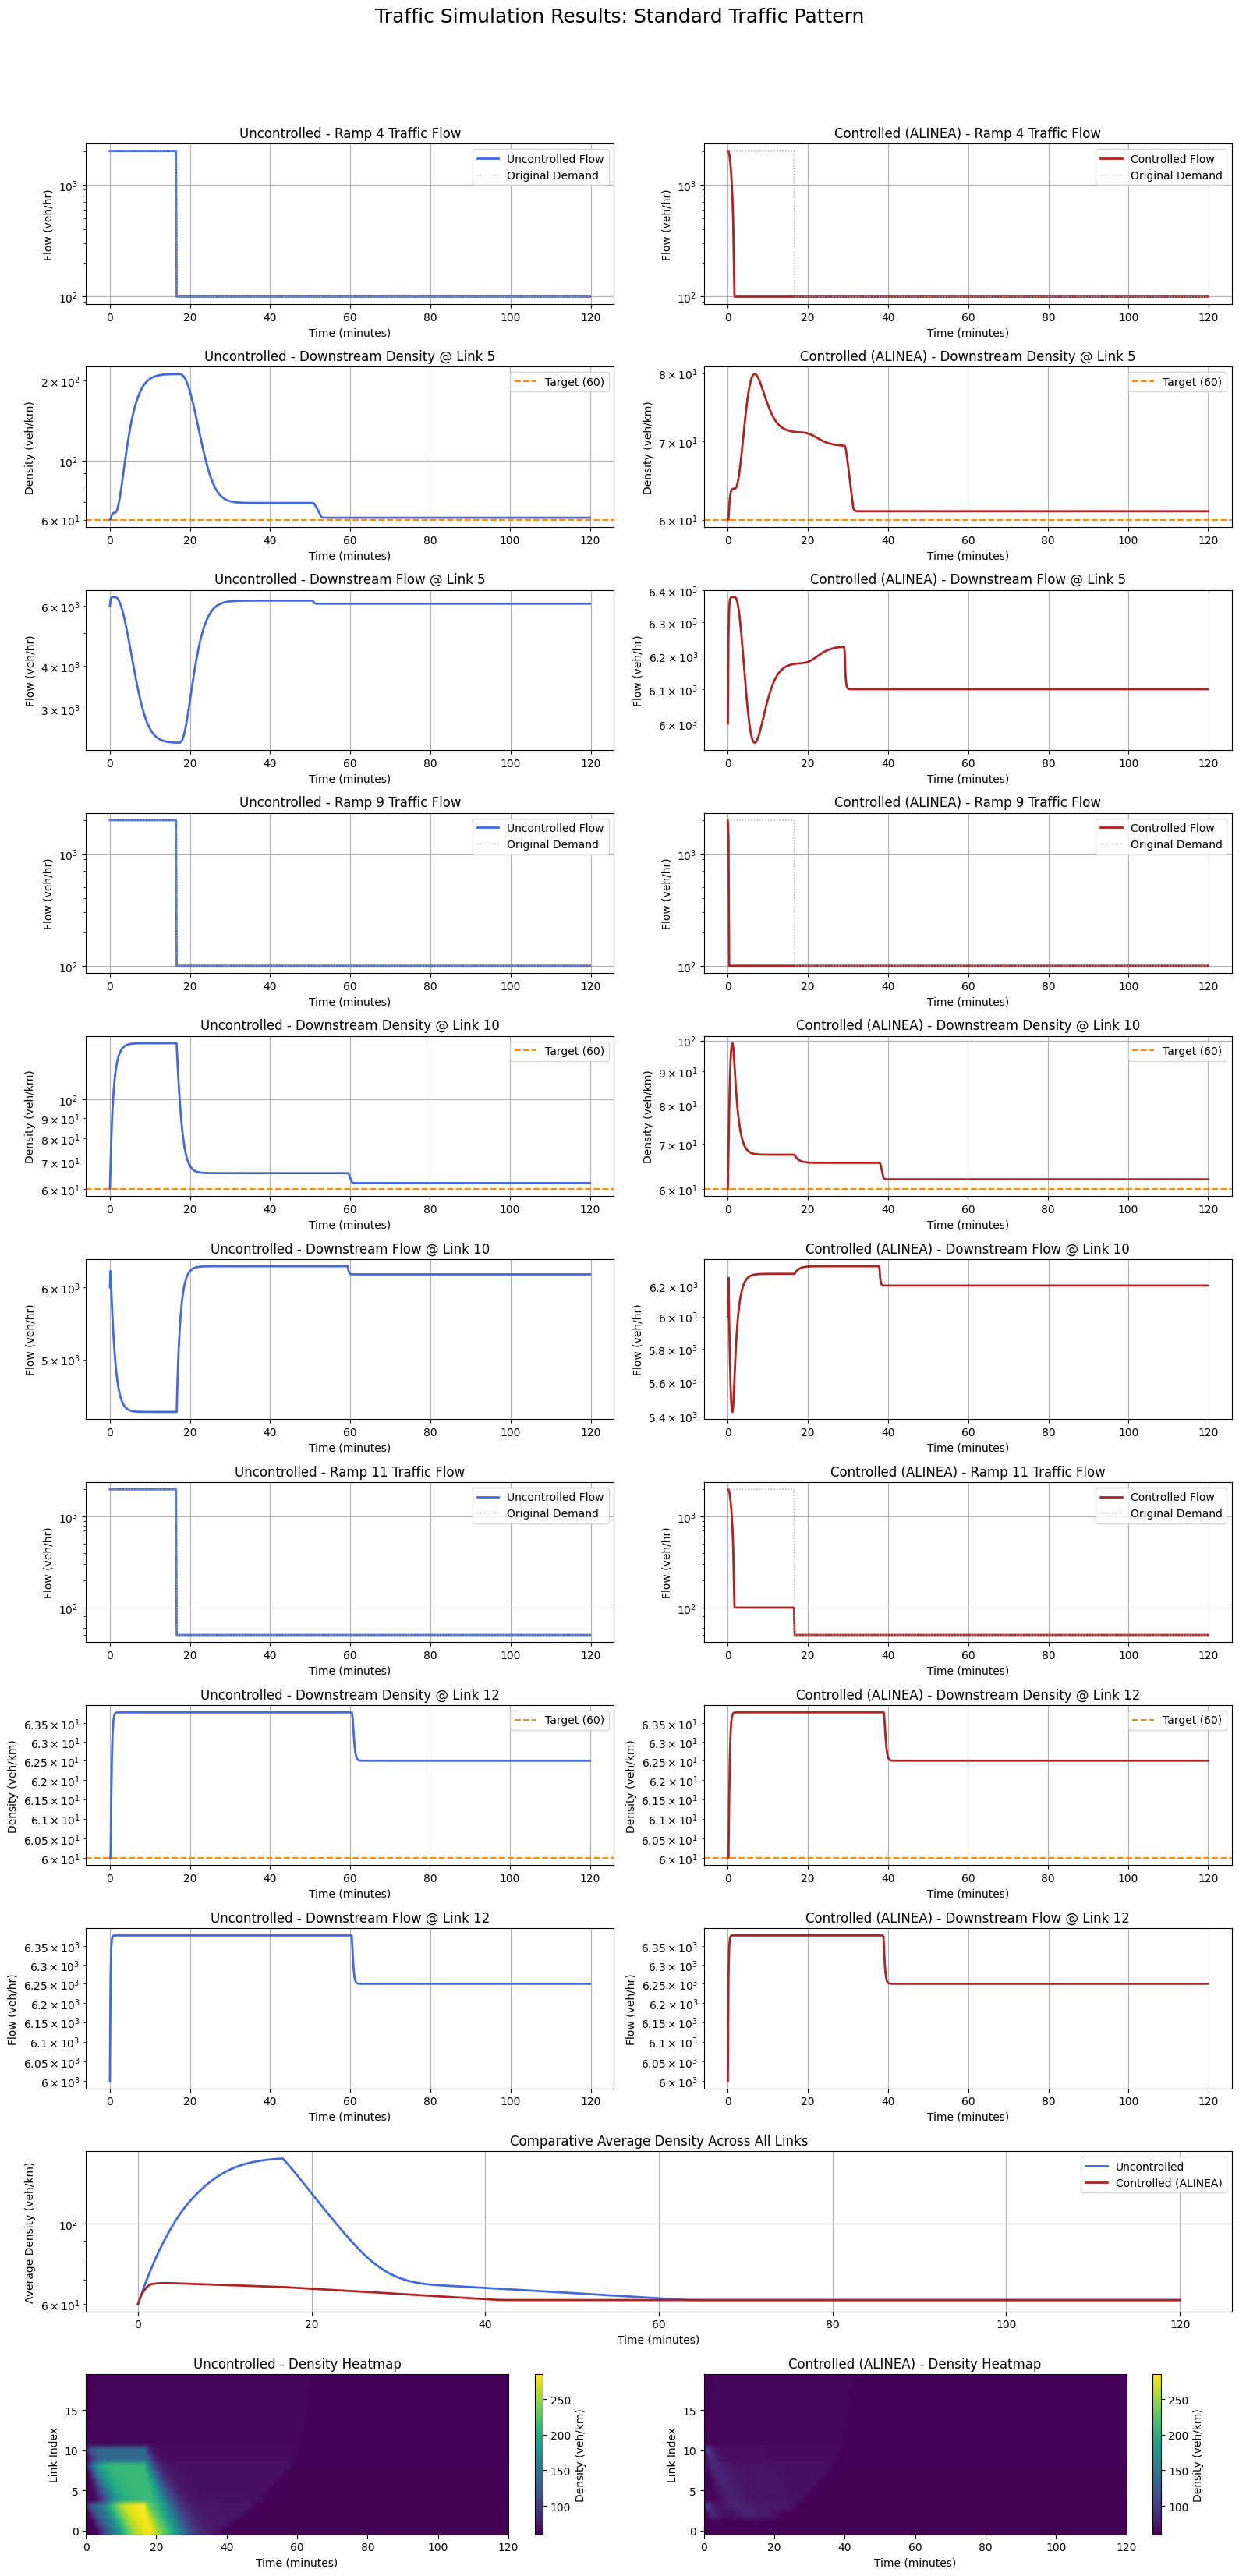

Plotting for Scenario: Persistent High Demand


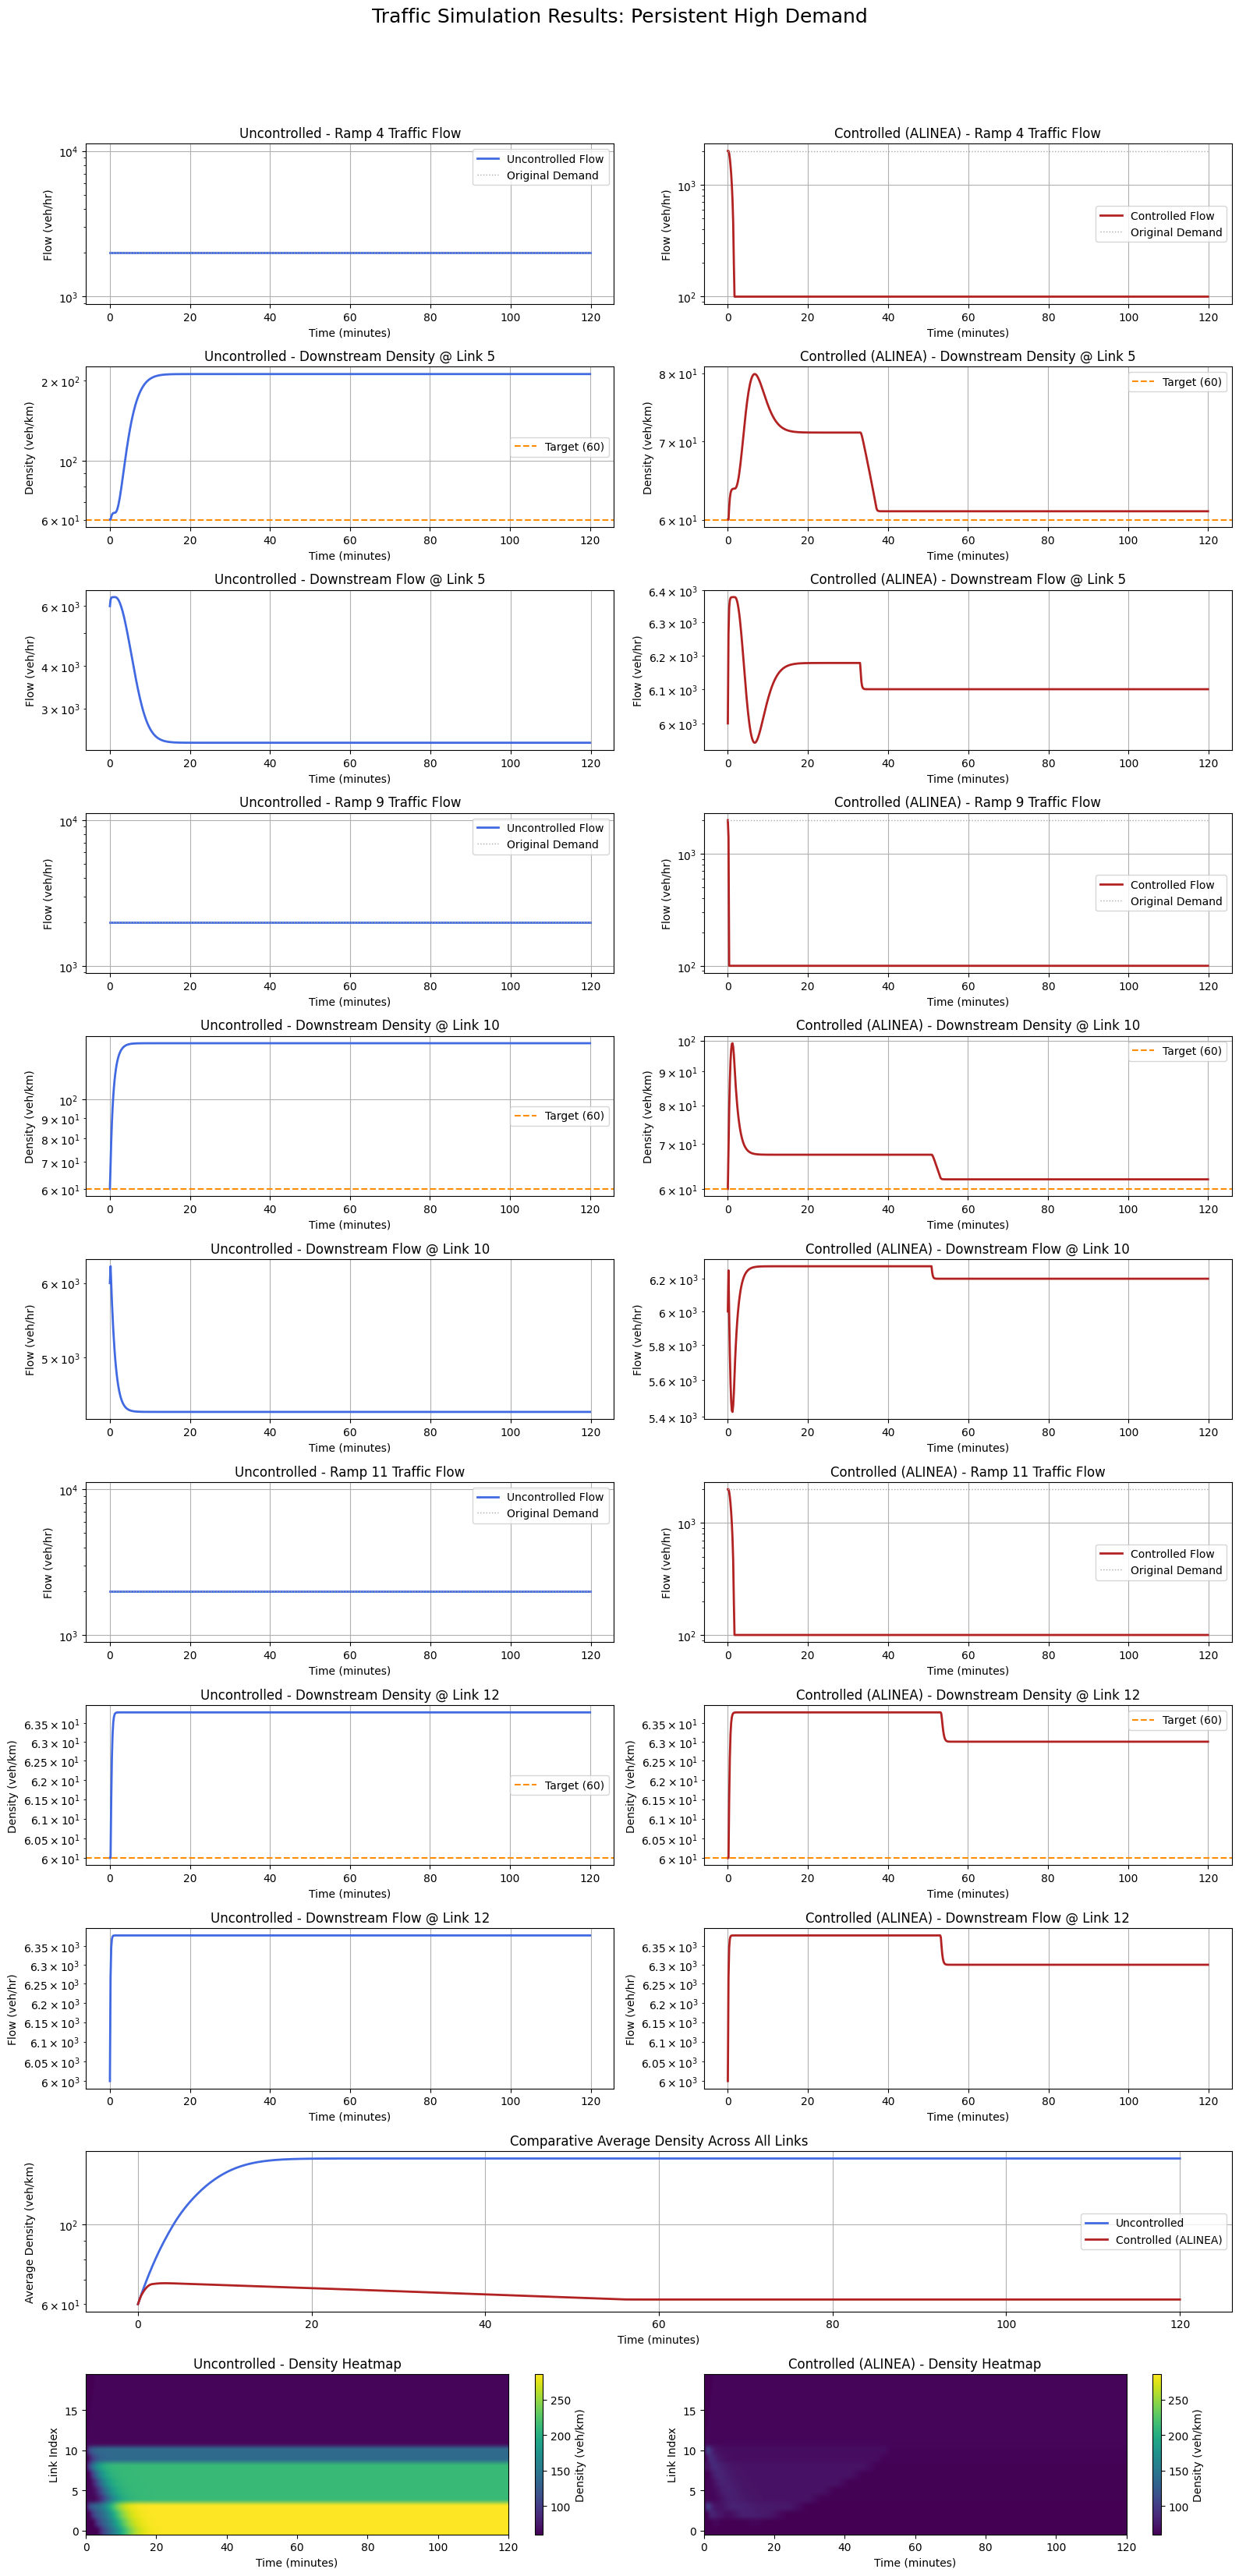

Plotting for Scenario: Fluctuating Demand


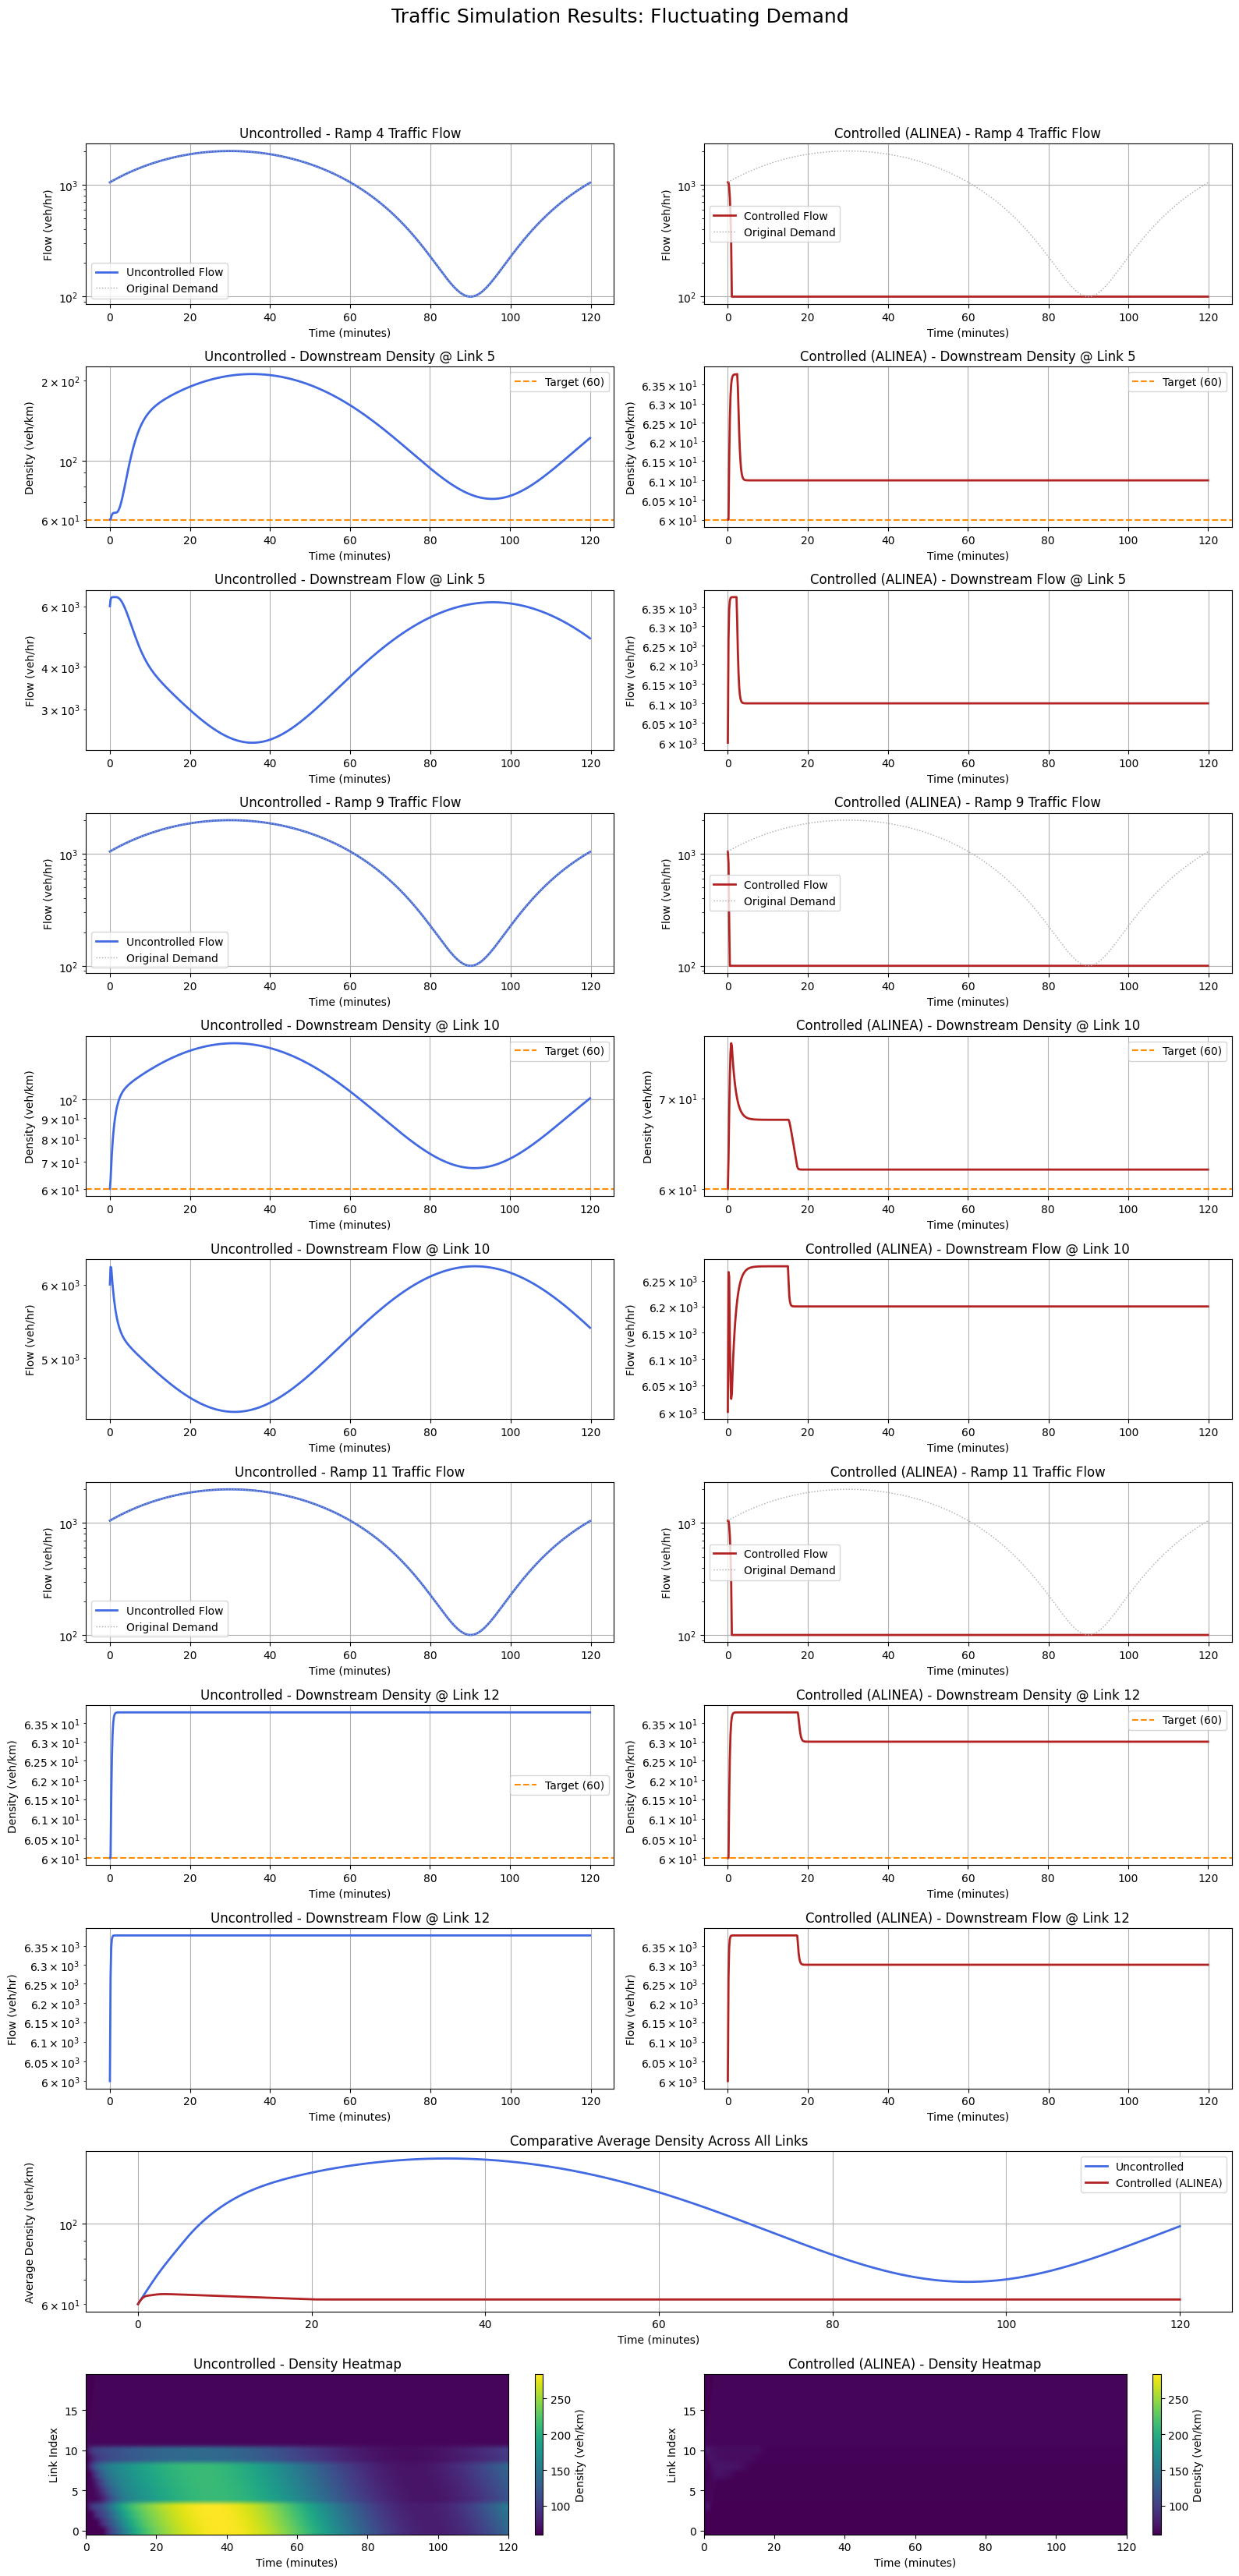

--- All Plotting Complete ---


In [ ]:
# --- PLOTTING RESULTS Logarithmic scale---

print("\n--- Generating Plots for All Scenarios ---")

for scenario_name, results_data in simulation_results.items():
    print(f"Plotting for Scenario: {scenario_name}")

    uncontrolled_data = results_data["uncontrolled"]
    controlled_data = results_data["controlled"]
    original_demand_data = results_data["original_demand"]
    ramp_section_indices = results_data["onramp_indices"]
    plot_target_density = results_data["target_density"]

    num_ramps_to_plot = len(ramp_section_indices)
    total_plot_rows = 3 * num_ramps_to_plot + 2 # 3 plots per ramp + 1 for overall avg + 1 for heatmaps

    fig = plt.figure(figsize=(16, 3 * total_plot_rows))
    gs = gridspec.GridSpec(total_plot_rows, 2, figure=fig)

    time_flow_plots = np.arange(TOTAL_TIMESTEPS) * TIME_STEP_HRS * 60      # Time in minutes for K steps
    time_density_plots = np.arange(TOTAL_TIMESTEPS + 1) * TIME_STEP_HRS * 60 # Time in minutes for K+1 steps

    # Loop over each on-ramp section
    for j, current_ramp_idx in enumerate(ramp_section_indices):
        # Determine the downstream section for plotting (must be within bounds)
        downstream_plot_idx = current_ramp_idx + 1 if current_ramp_idx < NUM_LINKS - 1 else current_ramp_idx

        # --- Uncontrolled Column Plots ---
        ax_ramp_flow_unc = fig.add_subplot(gs[3*j, 0])
        ax_ramp_flow_unc.plot(time_flow_plots, uncontrolled_data["ramp_flows"][current_ramp_idx, :], color='royalblue', linewidth=2, label='Uncontrolled Flow')
        ax_ramp_flow_unc.plot(time_flow_plots, original_demand_data[current_ramp_idx, :], color='darkgray', linestyle=':', linewidth=1, label='Original Demand')
        ax_ramp_flow_unc.set_title(f'Uncontrolled - Ramp {current_ramp_idx} Traffic Flow')
        ax_ramp_flow_unc.set_xlabel('Time (minutes)')
        ax_ramp_flow_unc.set_ylabel('Flow (veh/hr)')
        ax_ramp_flow_unc.set_yscale('log') # Set y-axis to logarithmic scale
        ax_ramp_flow_unc.legend()
        ax_ramp_flow_unc.grid(True)

        ax_down_density_unc = fig.add_subplot(gs[3*j + 1, 0])
        ax_down_density_unc.plot(time_density_plots, uncontrolled_data["densities"][downstream_plot_idx, :], color='royalblue', linewidth=2)
        ax_down_density_unc.axhline(y=plot_target_density, color='darkorange', linestyle='--', label=f'Target ({plot_target_density})')
        ax_down_density_unc.set_title(f'Uncontrolled - Downstream Density @ Link {downstream_plot_idx}')
        ax_down_density_unc.set_xlabel('Time (minutes)')
        ax_down_density_unc.set_ylabel('Density (veh/km)')
        ax_down_density_unc.set_yscale('log') # Set y-axis to logarithmic scale
        ax_down_density_unc.legend()
        ax_down_density_unc.grid(True)

        ax_down_flow_unc = fig.add_subplot(gs[3*j + 2, 0])
        if current_ramp_idx < NUM_LINKS - 1:
            downstream_flow_unc = uncontrolled_data["flows"][current_ramp_idx + 1, :]
        else: # For the very last link, its outflow is its mainline flow constrained by exit capacity
            downstream_flow_unc = np.minimum(free_flow_speed_arr[-1] * uncontrolled_data["densities"][current_ramp_idx, :TOTAL_TIMESTEPS], exit_flow_profile)
        ax_down_flow_unc.plot(time_flow_plots, downstream_flow_unc, color='royalblue', linewidth=2)
        ax_down_flow_unc.set_title(f'Uncontrolled - Downstream Flow @ Link {downstream_plot_idx}')
        ax_down_flow_unc.set_xlabel('Time (minutes)')
        ax_down_flow_unc.set_ylabel('Flow (veh/hr)')
        ax_down_flow_unc.set_yscale('log') # Set y-axis to logarithmic scale
        ax_down_flow_unc.grid(True)

        # --- ALINEA Controlled Column Plots ---
        ax_ramp_flow_ctrl = fig.add_subplot(gs[3*j, 1])
        ax_ramp_flow_ctrl.plot(time_flow_plots, controlled_data["ramp_flows"][current_ramp_idx, :], color='firebrick', linewidth=2, label='Controlled Flow')
        ax_ramp_flow_ctrl.plot(time_flow_plots, original_demand_data[current_ramp_idx, :], color='darkgray', linestyle=':', linewidth=1, label='Original Demand')
        ax_ramp_flow_ctrl.set_title(f'Controlled (ALINEA) - Ramp {current_ramp_idx} Traffic Flow')
        ax_ramp_flow_ctrl.set_xlabel('Time (minutes)')
        ax_ramp_flow_ctrl.set_ylabel('Flow (veh/hr)')
        ax_ramp_flow_ctrl.set_yscale('log') # Set y-axis to logarithmic scale
        ax_ramp_flow_ctrl.legend()
        ax_ramp_flow_ctrl.grid(True)

        ax_down_density_ctrl = fig.add_subplot(gs[3*j + 1, 1])
        ax_down_density_ctrl.plot(time_density_plots, controlled_data["densities"][downstream_plot_idx, :], color='firebrick', linewidth=2)
        ax_down_density_ctrl.axhline(y=plot_target_density, color='darkorange', linestyle='--', label=f'Target ({plot_target_density})')
        ax_down_density_ctrl.set_title(f'Controlled (ALINEA) - Downstream Density @ Link {downstream_plot_idx}')
        ax_down_density_ctrl.set_xlabel('Time (minutes)')
        ax_down_density_ctrl.set_ylabel('Density (veh/km)')
        ax_down_density_ctrl.set_yscale('log') # Set y-axis to logarithmic scale
        ax_down_density_ctrl.legend()
        ax_down_density_ctrl.grid(True)

        ax_down_flow_ctrl = fig.add_subplot(gs[3*j + 2, 1])
        if current_ramp_idx < NUM_LINKS - 1:
            downstream_flow_ctrl = controlled_data["flows"][current_ramp_idx + 1, :]
        else: # For the very last link, its outflow is its mainline flow constrained by exit capacity
            downstream_flow_ctrl = np.minimum(free_flow_speed_arr[-1] * controlled_data["densities"][current_ramp_idx, :TOTAL_TIMESTEPS], exit_flow_profile)
        ax_down_flow_ctrl.plot(time_flow_plots, downstream_flow_ctrl, color='firebrick', linewidth=2)
        ax_down_flow_ctrl.set_title(f'Controlled (ALINEA) - Downstream Flow @ Link {downstream_plot_idx}')
        ax_down_flow_ctrl.set_xlabel('Time (minutes)')
        ax_down_flow_ctrl.set_ylabel('Flow (veh/hr)')
        ax_down_flow_ctrl.set_yscale('log') # Set y-axis to logarithmic scale
        ax_down_flow_ctrl.grid(True)

    # --- Overall Average Density Comparison ---
    overall_avg_row = 3 * num_ramps_to_plot
    ax_overall_avg = fig.add_subplot(gs[overall_avg_row, :])
    avg_density_unc = np.mean(uncontrolled_data["densities"], axis=0)
    avg_density_ctrl = np.mean(controlled_data["densities"], axis=0)
    ax_overall_avg.plot(time_density_plots, avg_density_unc, color='royalblue', label='Uncontrolled', linewidth=2)
    ax_overall_avg.plot(time_density_plots, avg_density_ctrl, color='firebrick', label='Controlled (ALINEA)', linewidth=2)
    ax_overall_avg.set_title('Comparative Average Density Across All Links')
    ax_overall_avg.set_xlabel('Time (minutes)')
    ax_overall_avg.set_ylabel('Average Density (veh/km)')
    ax_overall_avg.set_yscale('log') # Set y-axis to logarithmic scale
    ax_overall_avg.legend()
    ax_overall_avg.grid(True)

    # --- Density Heatmaps ---
    heatmap_row = overall_avg_row + 1
    # For heatmaps, using a logarithmic colormap might not be intuitive or directly supported as a 'scale' on the colorbar.
    # Instead, you'd typically transform the data before passing it to imshow if you truly wanted a logarithmic representation of the color scale.
    # For now, we'll keep the vmin/vmax as is, as direct `set_yscale('log')` doesn't apply to colorbars.
    global_density_min = min(np.min(uncontrolled_data["densities"]), np.min(controlled_data["densities"]))
    global_density_max = max(np.max(uncontrolled_data["densities"]), np.max(controlled_data["densities"]))

    ax_heatmap_unc = fig.add_subplot(gs[heatmap_row, 0])
    im_unc_heatmap = ax_heatmap_unc.imshow(uncontrolled_data["densities"], aspect='auto', origin='lower',
                                             vmin=global_density_min, vmax=global_density_max, cmap='viridis',
                                             extent=[time_density_plots.min(), time_density_plots.max(), -0.5, NUM_LINKS - 0.5])
    ax_heatmap_unc.set_title('Uncontrolled - Density Heatmap')
    ax_heatmap_unc.set_xlabel('Time (minutes)')
    ax_heatmap_unc.set_ylabel('Link Index')
    fig.colorbar(im_unc_heatmap, ax=ax_heatmap_unc, label='Density (veh/km)')

    ax_heatmap_ctrl = fig.add_subplot(gs[heatmap_row, 1])
    im_ctrl_heatmap = ax_heatmap_ctrl.imshow(controlled_data["densities"], aspect='auto', origin='lower',
                                             vmin=global_density_min, vmax=global_density_max, cmap='viridis',
                                             extent=[time_density_plots.min(), time_density_plots.max(), -0.5, NUM_LINKS - 0.5])
    ax_heatmap_ctrl.set_title('Controlled (ALINEA) - Density Heatmap')
    ax_heatmap_ctrl.set_xlabel('Time (minutes)')
    ax_heatmap_ctrl.set_ylabel('Link Index')
    fig.colorbar(im_ctrl_heatmap, ax=ax_heatmap_ctrl, label='Density (veh/km)')

    fig.suptitle(f"Traffic Simulation Results: {scenario_name}", fontsize=18, y=1.0)
    fig.tight_layout(rect=[0, 0, 1, 0.97])
    plt.show()

print('--- All Plotting Complete ---')

--- Initiating Scenario: Standard Traffic Pattern ---
--- Scenario 'Standard Traffic Pattern' Completed ---
--- Initiating Scenario: Persistent High Demand ---
--- Scenario 'Persistent High Demand' Completed ---
--- Initiating Scenario: Fluctuating Demand ---
--- Scenario 'Fluctuating Demand' Completed ---

All Simulations Concluded.

--- Generating Plots for All Scenarios ---
Plotting for Scenario: Standard Traffic Pattern


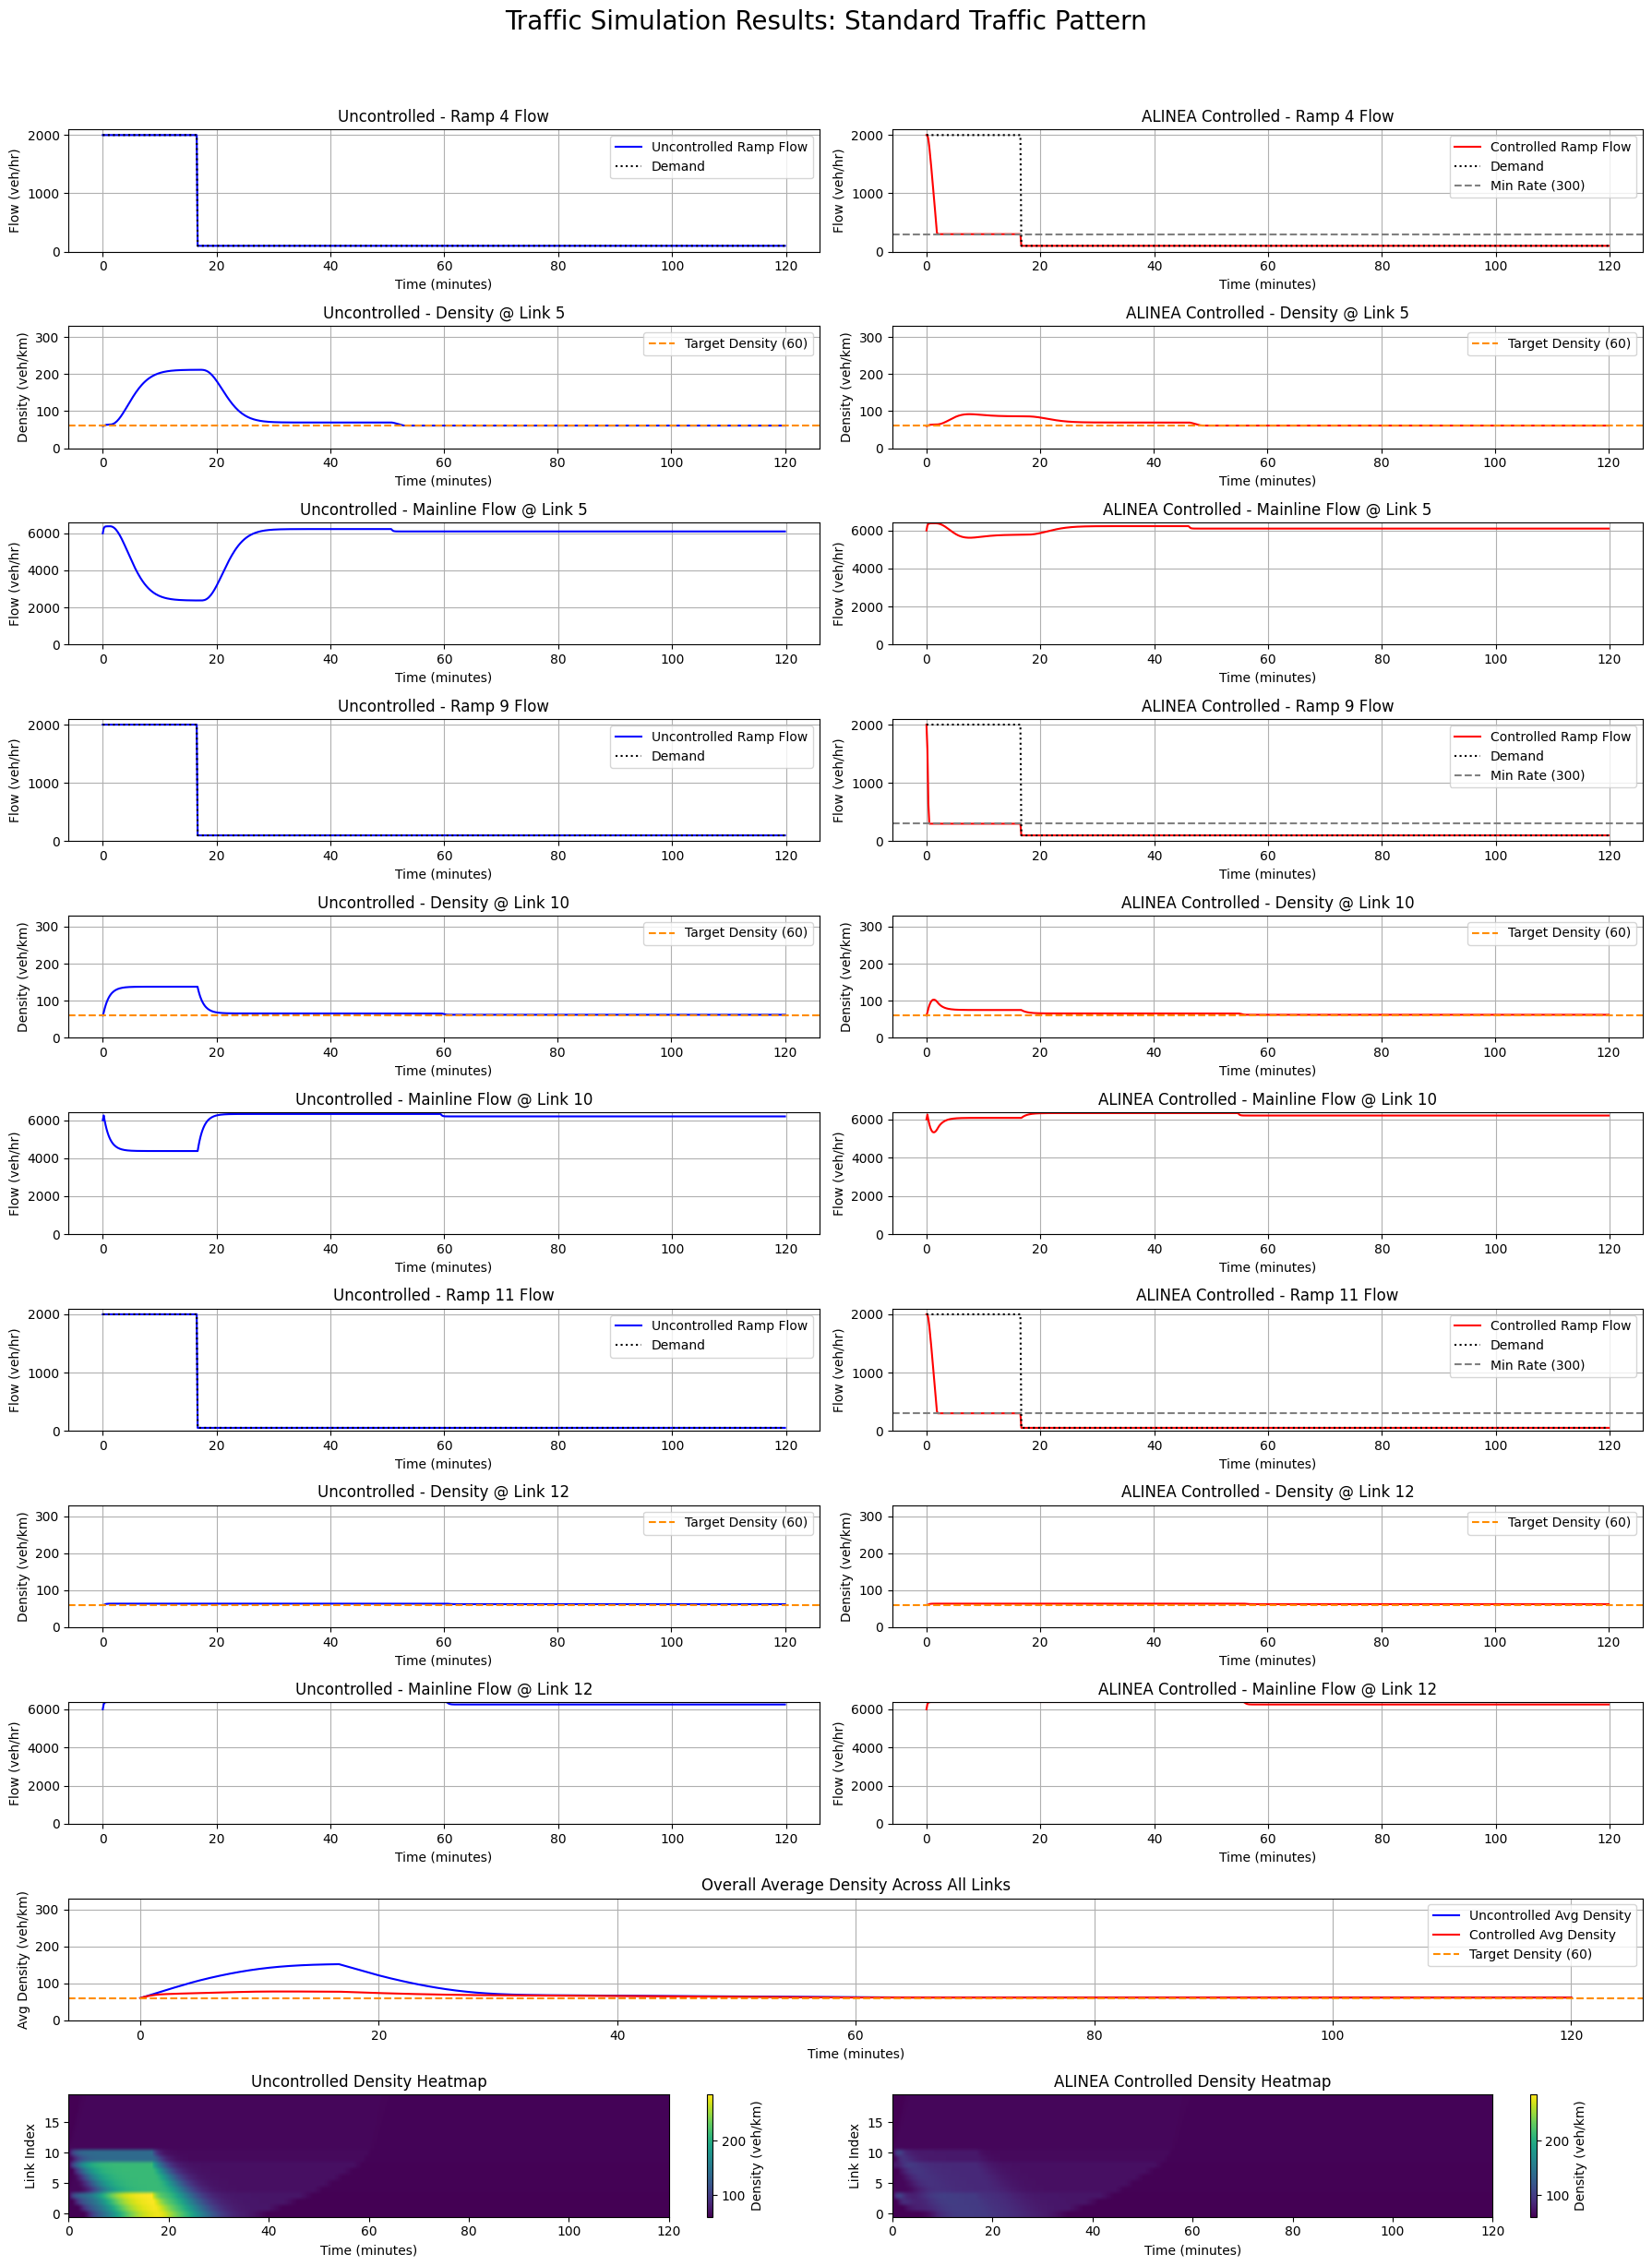

Plotting for Scenario: Persistent High Demand


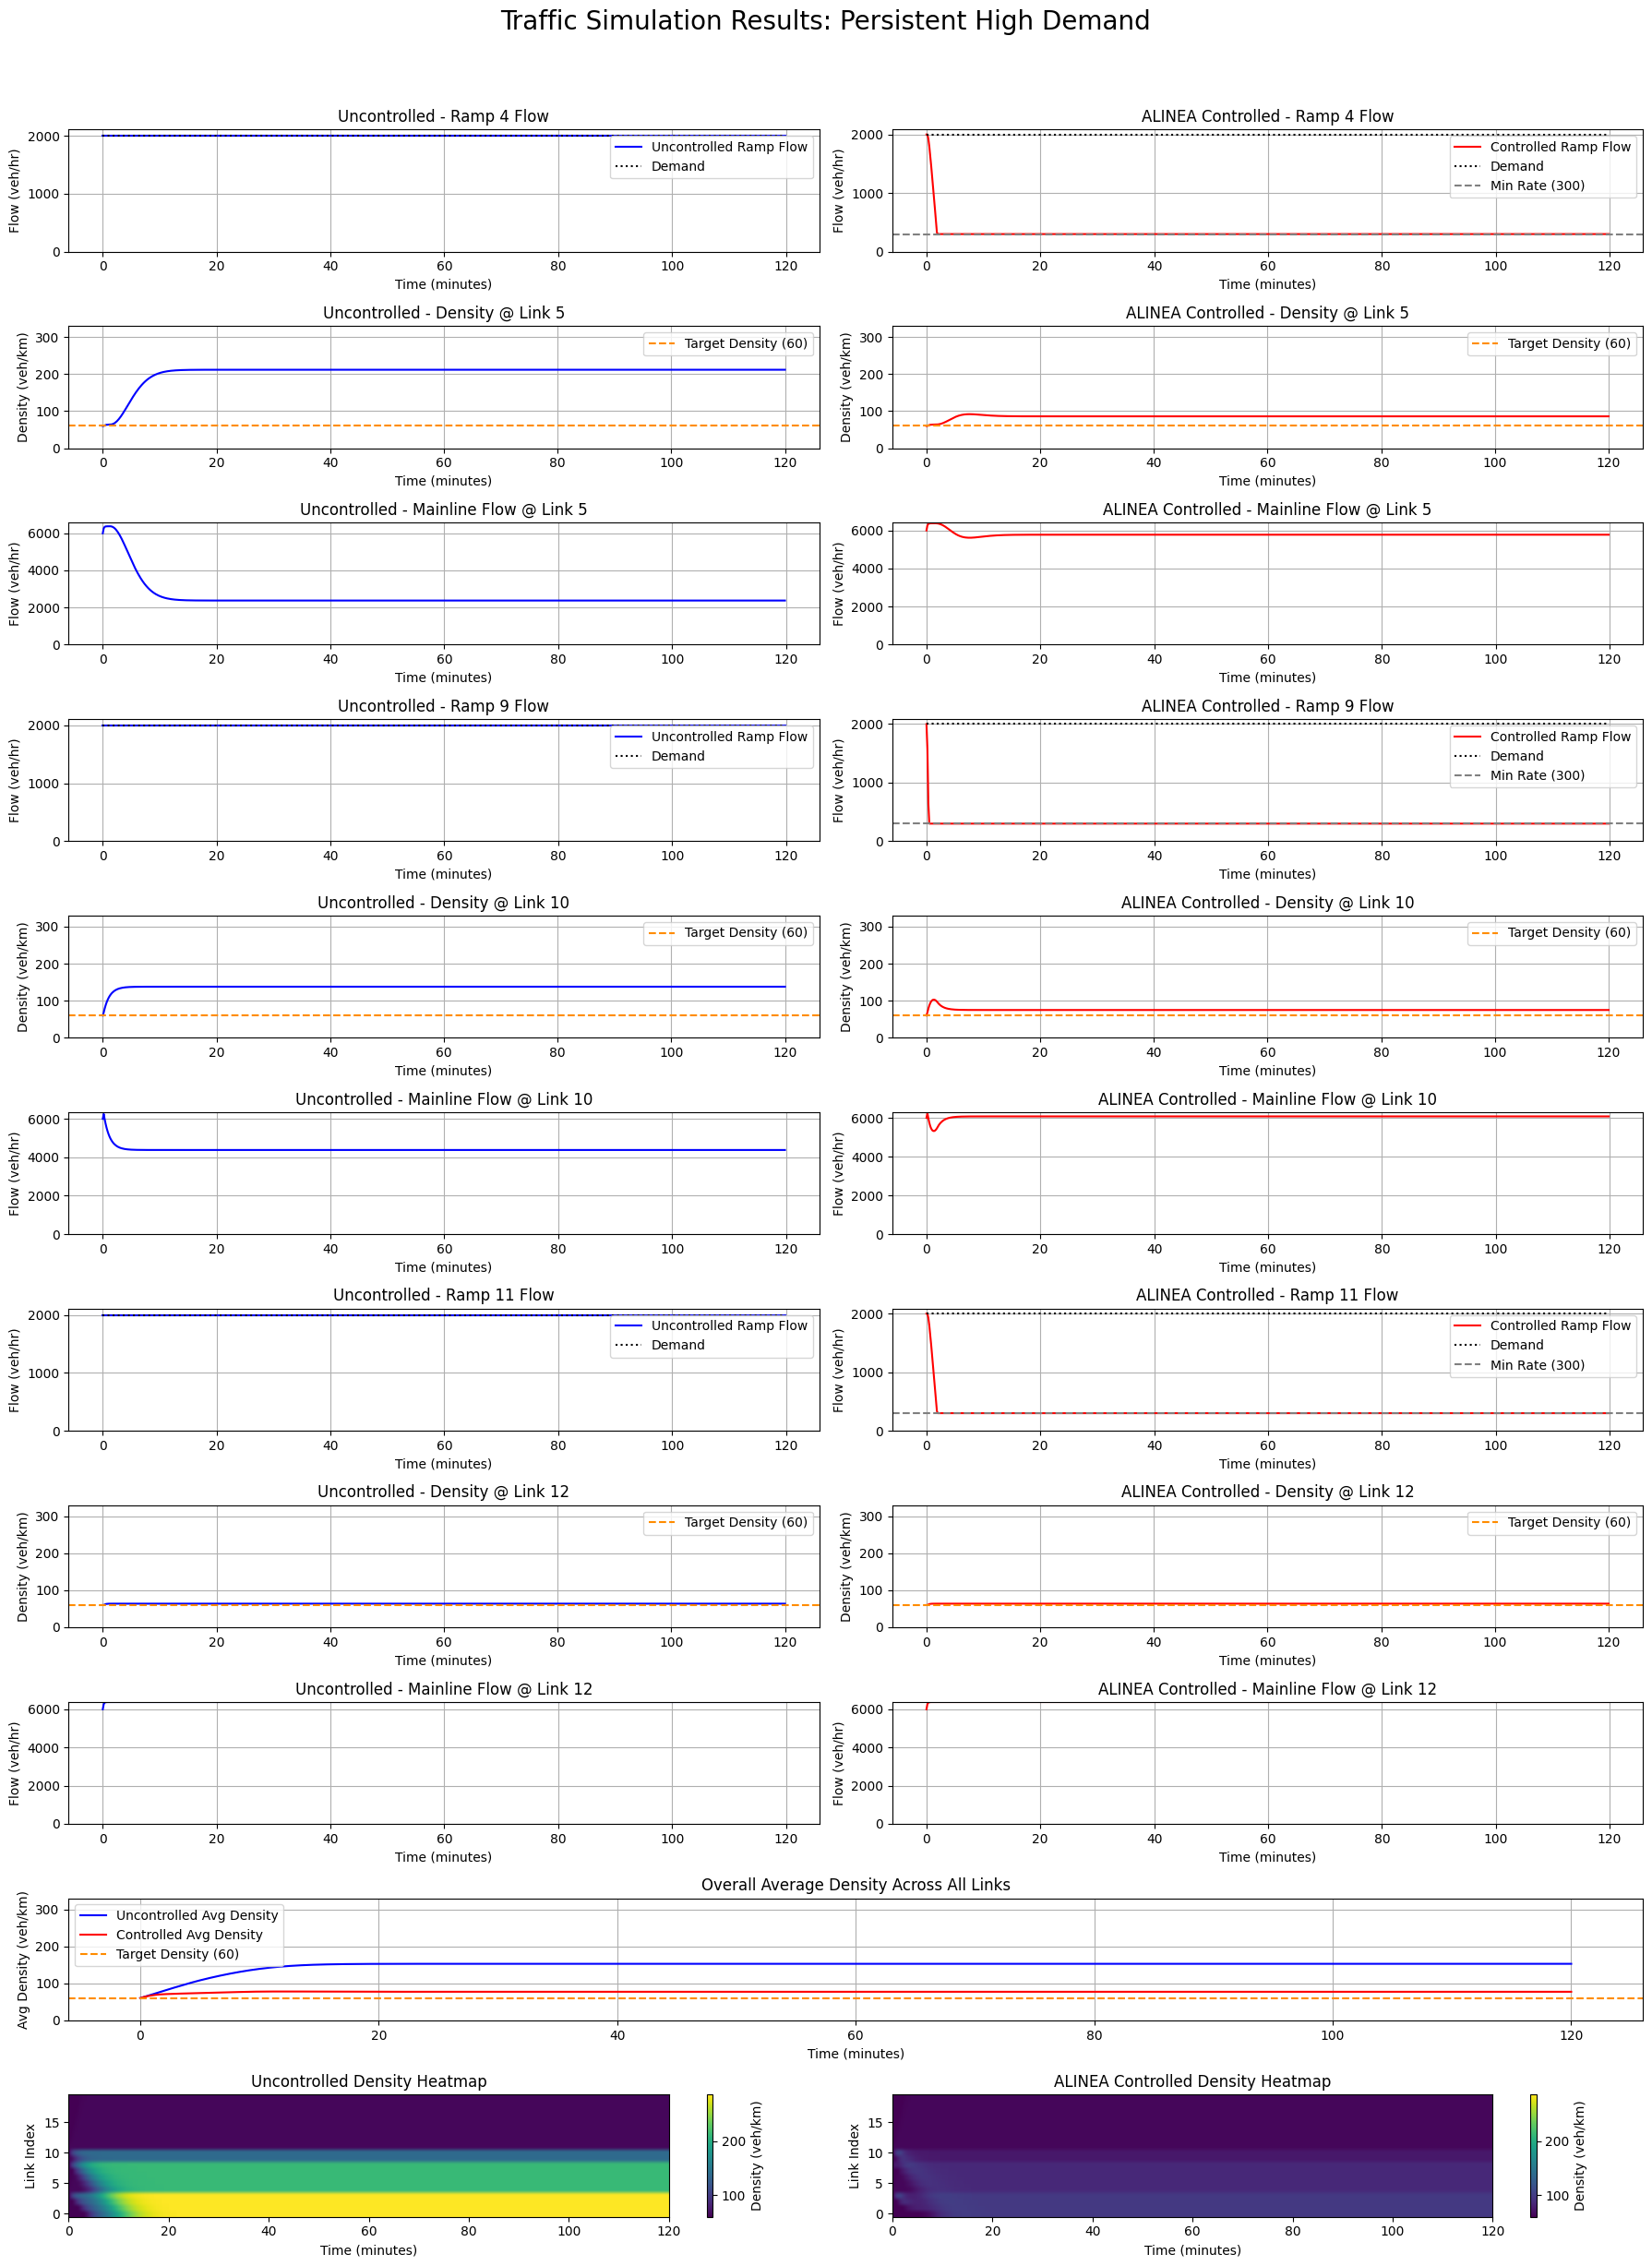

Plotting for Scenario: Fluctuating Demand


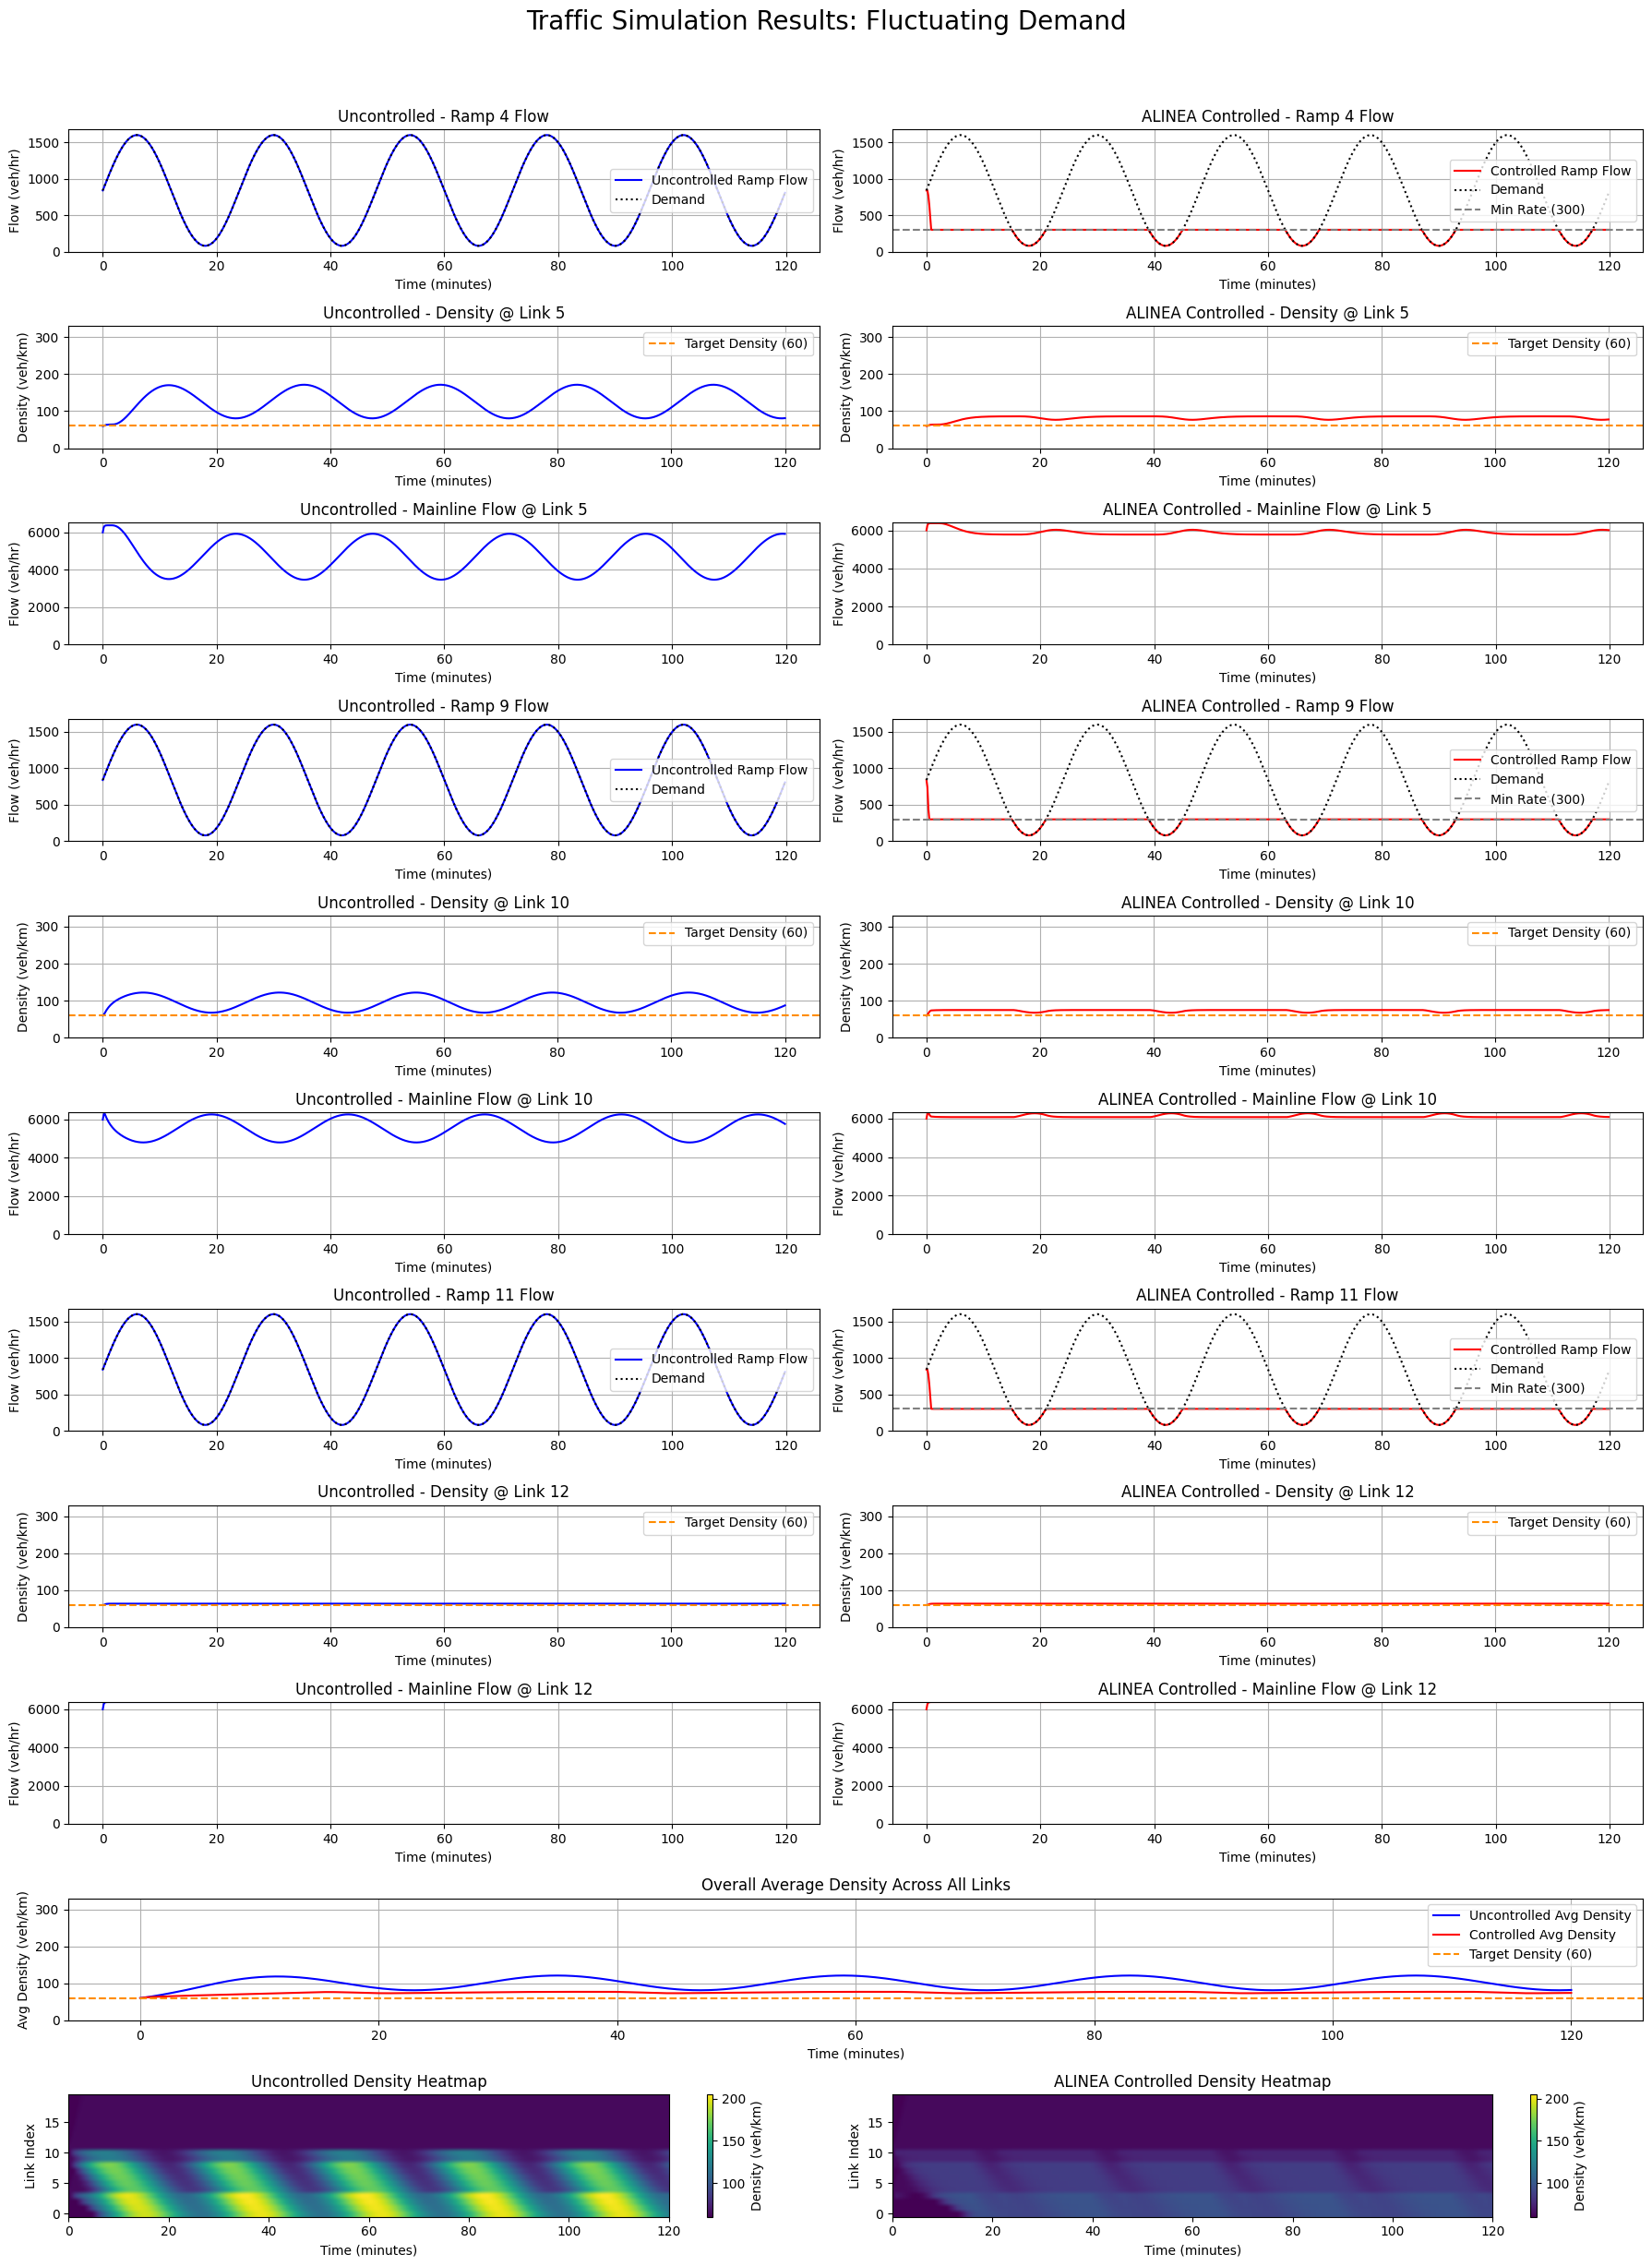

--- All Plotting Complete ---


In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec

def generate_traffic_demand(demand_scenario, total_timesteps, link_indices_with_onramps, high_demand_val, low_demand_val, num_links):
    """
    Creates a demand matrix (num_links, total_timesteps) for highway on-ramp sections.
    Demand is zero for mainline sections.
    If low_demand_val is None, default low values are applied:
    - 50 for link index 11
    - 100 for other on-ramp link indices.
    """
    flow_req = np.zeros((num_links, total_timesteps))

    if low_demand_val is None: # This applies to "Standard Traffic Pattern"
        low_val_map = {i: (50 if i == 11 else 100) for i in link_indices_with_onramps}
    else:
        low_val_map = {i: low_demand_val for i in link_indices_with_onramps}

    if demand_scenario == "baseline":
        for k in range(100):
            for i in link_indices_with_onramps:
                flow_req[i, k] = high_demand_val
        for k in range(100, total_timesteps):
            for i in link_indices_with_onramps:
                flow_req[i, k] = low_val_map[i]
    elif demand_scenario == "high_constant":
        for k in range(total_timesteps):
            for i in link_indices_with_onramps:
                flow_req[i, k] = high_demand_val
    elif demand_scenario == "low_constant": # Not used in your defined scenarios, but exists
        for k in range(total_timesteps):
            for i in link_indices_with_onramps:
                flow_req[i, k] = low_val_map[i]
    elif demand_scenario == "oscillatory":
        # Ensure all on-ramps get their specific low_val from potentially modified low_val_map
        # However, the current oscillatory formula uses a single low value for amplitude calculation.
        # Using the first on-ramp's low value for the base of oscillation:
        base_low_demand_for_oscillation = low_val_map[link_indices_with_onramps[0]]
        for k in range(total_timesteps):
            # Amplitude is based on the difference between high_demand_val and the specific base_low_demand
            amplitude = high_demand_val - base_low_demand_for_oscillation
            current_demand_val = base_low_demand_for_oscillation + (amplitude * 0.5 * (1 + np.sin(2 * np.pi * k * 5 / total_timesteps))) # Added factor 5 for more oscillations
            for i in link_indices_with_onramps:
                flow_req[i, k] = max(0, current_demand_val) # Ensure demand is not negative
    elif demand_scenario == "step_change": # Not used in your defined scenarios
        for k in range(total_timesteps):
            for i in link_indices_with_onramps:
                if k < total_timesteps // 2:
                    flow_req[i, k] = low_val_map[i]
                else:
                    flow_req[i, k] = high_demand_val
    elif demand_scenario == "random": # Not used in your defined scenarios
        for k in range(100):
            for i in link_indices_with_onramps:
                base_val = high_demand_val
                noise_val = np.random.normal(0, 100)
                flow_req[i, k] = max(0, base_val + noise_val)
        for k in range(100, total_timesteps):
            for i in link_indices_with_onramps:
                base_val = low_val_map[i]
                noise_val = np.random.normal(0, 50)
                flow_req[i, k] = max(0, base_val + noise_val)
    else: # Default to baseline
        for k in range(100):
            for i in link_indices_with_onramps:
                flow_req[i, k] = high_demand_val
        for k in range(100, total_timesteps):
            for i in link_indices_with_onramps:
                flow_req[i, k] = low_val_map[i]
    return flow_req


def run_traffic_simulation(num_links, total_timesteps, time_step, link_lengths, max_density,
                           free_flow_speed, congestion_wave_speed, initial_density,
                           initial_flow, entry_density, entry_flow, exit_density, exit_flow,
                           demand_matrix, onramp_indicators, alinea_gain, target_density,
                           max_metering_rate, min_metering_rate):
    """
    Executes simulations for both an uncontrolled scenario (open-loop) and a controlled
    scenario using a modified ALINEA logic (closed-loop) with downstream density feedback.

    Returns a dictionary containing simulation results for both cases:
      - "uncontrolled": { "densities": density_unc, "flows": flow_unc, "ramp_flows": ramp_unc }
      - "controlled":   { "densities": density_ctrl, "flows": flow_ctrl, "ramp_flows": ramp_ctrl }
    """

    # --- Uncontrolled Simulation ---
    density_unc = np.zeros((num_links, total_timesteps + 1))
    flow_unc = np.zeros((num_links, total_timesteps))
    ramp_unc = demand_matrix.copy()  # On-ramp flows follow demand without control.

    density_unc[:, 0] = initial_density[:]
    density_unc[:, 0] = np.clip(density_unc[:, 0], 0, max_density)

    for k in range(total_timesteps):
        # Calculate flows using CTM
        # Flow into link 0 (from entry)
        flow_unc[0, k] = min(entry_flow[k], congestion_wave_speed[0] * (max_density[0] - density_unc[0, k]) - ramp_unc[0, k]) # ramp_unc[0,k] is typically 0 if link 0 is not an onramp
        flow_unc[0, k] = max(0, flow_unc[0, k])
        # Flows for subsequent links (i from i-1)
        for i in range(1, num_links):
            flow_unc[i, k] = min(free_flow_speed[i - 1] * density_unc[i - 1, k],
                                 congestion_wave_speed[i] * (max_density[i] - density_unc[i, k]) - ramp_unc[i, k])
            flow_unc[i, k] = max(0, flow_unc[i, k])

        # Update densities using CTM
        for i in range(num_links - 1): # For all links except the last one
            density_unc[i, k + 1] = density_unc[i, k] + time_step / link_lengths[i] * (flow_unc[i, k] + ramp_unc[i, k] - flow_unc[i + 1, k])

        # Handle last link's density update (outflow is to exit)
        current_outflow_unc = min(free_flow_speed[num_links - 1] * density_unc[num_links - 1, k], exit_flow[k])
        current_outflow_unc = max(0, current_outflow_unc) # ensure non-negative
        density_unc[num_links - 1, k + 1] = density_unc[num_links - 1, k] + time_step / link_lengths[num_links - 1] * \
                                          (flow_unc[num_links - 1, k] + ramp_unc[num_links - 1, k] - current_outflow_unc)
        density_unc[:, k + 1] = np.clip(density_unc[:, k + 1], 0, max_density)

    # --- ALINEA Control Simulation ---
    density_ctrl = np.zeros((num_links, total_timesteps + 1))
    flow_ctrl = np.zeros((num_links, total_timesteps))
    ramp_ctrl = np.zeros((num_links, total_timesteps))

    density_ctrl[:, 0] = initial_density[:]
    density_ctrl[:, 0] = np.clip(density_ctrl[:, 0], 0, max_density)

    prev_alinea_rate = np.full(num_links, max_metering_rate)

    for k in range(total_timesteps):
        # A. ALINEA Controller Calculation
        for i in range(num_links):
            if onramp_indicators[i] == 1:
                if i < num_links - 1:
                    measured_density = density_ctrl[i + 1, k]
                    calculated_rate = prev_alinea_rate[i] + alinea_gain * (target_density - measured_density)
                    desired_rate = np.clip(calculated_rate, min_metering_rate, max_metering_rate)
                    ramp_ctrl[i, k] = min(desired_rate, demand_matrix[i, k])
                    ramp_ctrl[i, k] = max(0, ramp_ctrl[i,k]) # Ensure ramp flow is not negative
                    prev_alinea_rate[i] = ramp_ctrl[i, k] # Using actual flow for prev_rate
                else:
                    ramp_ctrl[i, k] = demand_matrix[i, k] # Fallback for ramp on last link
                    prev_alinea_rate[i] = ramp_ctrl[i, k]
            else:
                ramp_ctrl[i, k] = 0 # No ramp flow for non-ramp links

        # B. CTM Calculation using the ALINEA-controlled ramp flow
        # Flow into link 0 (from entry)
        flow_ctrl[0, k] = min(entry_flow[k], congestion_wave_speed[0] * (max_density[0] - density_ctrl[0, k]) - ramp_ctrl[0, k])
        flow_ctrl[0, k] = max(0, flow_ctrl[0, k])
        # Flows for subsequent links (i from i-1)
        for i in range(1, num_links):
            flow_ctrl[i, k] = min(free_flow_speed[i - 1] * density_ctrl[i - 1, k],
                                  congestion_wave_speed[i] * (max_density[i] - density_ctrl[i, k]) - ramp_ctrl[i, k])
            flow_ctrl[i, k] = max(0, flow_ctrl[i, k])

        # Update densities
        for i in range(num_links - 1): # For all links except the last one
            density_ctrl[i, k + 1] = density_ctrl[i, k] + time_step / link_lengths[i] * (flow_ctrl[i, k] + ramp_ctrl[i, k] - flow_ctrl[i + 1, k])

        # Handle last link's density update
        current_outflow_ctrl = min(free_flow_speed[num_links - 1] * density_ctrl[num_links - 1, k], exit_flow[k])
        current_outflow_ctrl = max(0, current_outflow_ctrl) # ensure non-negative
        density_ctrl[num_links - 1, k + 1] = density_ctrl[num_links - 1, k] + time_step / link_lengths[num_links - 1] * \
                                           (flow_ctrl[num_links - 1, k] + ramp_ctrl[num_links - 1, k] - current_outflow_ctrl)
        density_ctrl[:, k + 1] = np.clip(density_ctrl[:, k + 1], 0, max_density)

    return {"uncontrolled": {"densities": density_unc, "flows": flow_unc, "ramp_flows": ramp_unc},
            "controlled":   {"densities": density_ctrl, "flows": flow_ctrl, "ramp_flows": ramp_ctrl}}

# Global simulation parameters
NUM_LINKS = 20          # Number of highway sections
TOTAL_TIMESTEPS = 360 * 2  # 2 hours simulation with 10-second sampling -> 720 steps
TIME_STEP_HRS = 10 / 3600  # 10 seconds converted to hours
LINK_LENGTHS_KM = np.full(NUM_LINKS, 0.5) # Section lengths in kilometers
CONGESTION_WAVE_SPEED_KMPH = np.full(NUM_LINKS, 27) # Congested wave speed in km/h (w)

# Boundary conditions for the first and last sections
DEFAULT_ENTRY_DENSITY = 60
DEFAULT_EXIT_DENSITY = 80 # This is a fairly high exit density, can act as a bottleneck if not managed
entry_density_profile = np.full(TOTAL_TIMESTEPS, DEFAULT_ENTRY_DENSITY)
# Assuming a free-flow speed of 100 for boundary flow calculation for simplicity
# This should ideally use the free_flow_speed_arr[0] if it can vary per scenario
entry_flow_profile = entry_density_profile * 100 # vf * rho_entry
exit_density_profile = np.full(TOTAL_TIMESTEPS, DEFAULT_EXIT_DENSITY)
# This exit_flow should represent capacity or demand at exit.
# If it's capacity: Q_max_exit or w*(rho_max - rho_exit)
# If it's demand: can be high
exit_flow_profile = exit_density_profile * 100 # Simplistic, may need to be Q_max or W(rho_max - rho_exit_actual) for realism

# Controller parameters (for the ALINEA-like control)
CONTROLLER_GAIN = 50      # MODIFIED: Controller gain value (was 70)
TARGET_DENSITY = 60       # Target mainline density (veh/km) - comparable to critical density
MAX_METERING_RATE = 2000  # Maximum allowed ramp metering rate (veh/h)
MIN_METERING_RATE = 300   # MODIFIED: Minimum allowed ramp metering rate (veh/h) (was 100)

# Traffic Scenarios
simulation_scenarios = [
    {"name": "Standard Traffic Pattern",
     "demand_type": "baseline",
     "onramp_link_indices": [4, 9, 11], # Ramps at links 4, 9, 11
     "peak_demand_value": 2000,         # veh/hr
     "offpeak_demand_value": None,      # Uses default map in generate_traffic_demand (100 for 4,9; 50 for 11)
     "initial_link_density": 60,        # veh/km
     "link_free_flow_speed": 100,       # km/hr (vf)
     "link_max_density": 300},          # veh/km (rho_jam)

    {"name": "Persistent High Demand",
     "demand_type": "high_constant",
     "onramp_link_indices": [4, 9, 11],
     "peak_demand_value": 2000,         # This is high_demand_val
     "offpeak_demand_value": 2000,      # This is low_demand_val (effectively making it constant high)
     "initial_link_density": 60,
     "link_free_flow_speed": 100,
     "link_max_density": 300},

    {"name": "Fluctuating Demand",
     "demand_type": "oscillatory",
     "onramp_link_indices": [4, 9, 11],
     "peak_demand_value": 1600,         # MODIFIED: (was 2000)
     "offpeak_demand_value": 80,       # MODIFIED: (was 100)
     "initial_link_density": 60,
     "link_free_flow_speed": 100,
     "link_max_density": 300},
]
# --- SIMULATION EXECUTION LOOP ---

simulation_results = {}

for scenario in simulation_scenarios:
    print(f"--- Initiating Scenario: {scenario['name']} ---")

    initial_density_val = scenario.get("initial_link_density", 60)
    current_initial_density = np.full(NUM_LINKS, initial_density_val)

    link_free_flow_speed_val = scenario.get("link_free_flow_speed", 100)
    current_initial_flow = current_initial_density * link_free_flow_speed_val # Unused parameter in func

    # Boundary conditions (can be scenario specific if keys exist in dict)
    # Using global defaults here as they are not in scenario dicts
    current_entry_density_profile = np.full(TOTAL_TIMESTEPS, scenario.get("entry_density", DEFAULT_ENTRY_DENSITY))
    # Recalculate entry_flow based on scenario's free_flow_speed for consistency if it varied
    # Though here it's fixed at 100 globally for boundary flow calculation
    current_entry_flow_profile = current_entry_density_profile * link_free_flow_speed_val

    current_exit_density_profile = np.full(TOTAL_TIMESTEPS, scenario.get("exit_density", DEFAULT_EXIT_DENSITY))
    # Similar for exit_flow_profile
    current_exit_flow_profile = current_exit_density_profile * link_free_flow_speed_val

    free_flow_speed_arr = np.full(NUM_LINKS, link_free_flow_speed_val)
    max_density_val = scenario.get("link_max_density", 300)
    max_density_arr = np.full(NUM_LINKS, max_density_val)

    onramp_link_indices = scenario["onramp_link_indices"]
    onramp_indicator_arr = np.zeros(NUM_LINKS)
    for idx in onramp_link_indices:
        if 0 <= idx < NUM_LINKS: # Basic check
            onramp_indicator_arr[idx] = 1

    current_demand_matrix = generate_traffic_demand(
        demand_scenario=scenario["demand_type"],
        total_timesteps=TOTAL_TIMESTEPS,
        link_indices_with_onramps=onramp_link_indices,
        high_demand_val=scenario["peak_demand_value"],
        low_demand_val=scenario["offpeak_demand_value"],
        num_links=NUM_LINKS
    )

    scenario_output = run_traffic_simulation(
        NUM_LINKS, TOTAL_TIMESTEPS, TIME_STEP_HRS, LINK_LENGTHS_KM, max_density_arr,
        free_flow_speed_arr, CONGESTION_WAVE_SPEED_KMPH, current_initial_density,
        current_initial_flow, # This parameter is not used in run_traffic_simulation
        current_entry_density_profile, current_entry_flow_profile,
        current_exit_density_profile, current_exit_flow_profile, current_demand_matrix,
        onramp_indicator_arr, CONTROLLER_GAIN, TARGET_DENSITY,
        MAX_METERING_RATE, MIN_METERING_RATE
    )
    simulation_results[scenario['name']] = scenario_output
    simulation_results[scenario['name']]['original_demand'] = current_demand_matrix
    simulation_results[scenario['name']]['onramp_indices'] = onramp_link_indices
    simulation_results[scenario['name']]['target_density'] = TARGET_DENSITY
    simulation_results[scenario['name']]['link_max_density_val'] = max_density_val # For plotting
    simulation_results[scenario['name']]['link_free_flow_speed_val'] = link_free_flow_speed_val # For plotting

    print(f"--- Scenario '{scenario['name']}' Completed ---")

print('\nAll Simulations Concluded.')

# --- PLOTTING RESULTS ---

print("\n--- Generating Plots for All Scenarios ---")

for scenario_name, results_data in simulation_results.items():
    print(f"Plotting for Scenario: {scenario_name}")

    uncontrolled_data = results_data["uncontrolled"]
    controlled_data = results_data["controlled"]
    original_demand_data = results_data["original_demand"]
    ramp_section_indices = results_data["onramp_indices"] # e.g. [4, 9, 11]
    plot_target_density = results_data["target_density"]

    # Retrieve these for accurate plotting if they vary by scenario
    # For exit flow calculation in plots if needed
    current_ffs_val = results_data['link_free_flow_speed_val']
    # For y-axis limits, etc.
    current_max_density_val = results_data['link_max_density_val']

    # Define which links to plot (ramps and their downstream)
    # We'll plot for each ramp specified in onramp_link_indices
    # and its corresponding downstream link (ramp_idx + 1)

    num_ramps_to_plot_detailed = len(ramp_section_indices)
    # 3 plot types per ramp (ramp flow, downstream density, downstream flow)
    # + 1 for overall network average density comparison
    # + 1 for density heatmaps (uncontrolled vs controlled)
    total_plot_rows = (3 * num_ramps_to_plot_detailed) + 2

    fig = plt.figure(figsize=(18, 5 * num_ramps_to_plot_detailed + 10)) # Adjusted figure size
    # gs = gridspec.GridSpec(total_plot_rows, 2, figure=fig, hspace=0.4, wspace=0.3)
    # Use a more flexible GridSpec: one column for text, 2 for side-by-side plots.
    # Create a layout: (ramp_flow_unc, ramp_flow_ctrl), (density_unc, density_ctrl), etc.

    time_axis_minutes_flow = np.arange(TOTAL_TIMESTEPS) * TIME_STEP_HRS * 60      # For flow plots (k steps)
    time_axis_minutes_density = np.arange(TOTAL_TIMESTEPS + 1) * TIME_STEP_HRS * 60 # For density plots (k+1 steps)

    plot_row_idx = 0 # Keep track of current row in GridSpec

    for j, ramp_idx in enumerate(ramp_section_indices):
        downstream_mainline_idx = ramp_idx + 1
        if downstream_mainline_idx >= NUM_LINKS: # Should not happen if ramp is not on last link
            downstream_mainline_idx = NUM_LINKS - 1

        # Plot Ramp Flow for ramp_idx
        ax_rf_unc = fig.add_subplot(total_plot_rows, 2, (plot_row_idx * 2) + 1)
        ax_rf_unc.plot(time_axis_minutes_flow, uncontrolled_data["ramp_flows"][ramp_idx, :], 'b-', label='Uncontrolled Ramp Flow')
        ax_rf_unc.plot(time_axis_minutes_flow, original_demand_data[ramp_idx, :], 'k:', label='Demand')
        ax_rf_unc.set_title(f'Uncontrolled - Ramp {ramp_idx} Flow')
        ax_rf_unc.set_xlabel('Time (minutes)')
        ax_rf_unc.set_ylabel('Flow (veh/hr)')
        ax_rf_unc.legend()
        ax_rf_unc.grid(True)
        ax_rf_unc.set_ylim(bottom=0)

        ax_rf_ctrl = fig.add_subplot(total_plot_rows, 2, (plot_row_idx * 2) + 2)
        ax_rf_ctrl.plot(time_axis_minutes_flow, controlled_data["ramp_flows"][ramp_idx, :], 'r-', label='Controlled Ramp Flow')
        ax_rf_ctrl.plot(time_axis_minutes_flow, original_demand_data[ramp_idx, :], 'k:', label='Demand')
        ax_rf_ctrl.axhline(y=MIN_METERING_RATE, color='gray', linestyle='--', label=f'Min Rate ({MIN_METERING_RATE})')
        ax_rf_ctrl.set_title(f'ALINEA Controlled - Ramp {ramp_idx} Flow')
        ax_rf_ctrl.set_xlabel('Time (minutes)')
        ax_rf_ctrl.set_ylabel('Flow (veh/hr)')
        ax_rf_ctrl.legend()
        ax_rf_ctrl.grid(True)
        ax_rf_ctrl.set_ylim(bottom=0)
        plot_row_idx += 1

        # Plot Downstream Density for downstream_mainline_idx
        ax_dd_unc = fig.add_subplot(total_plot_rows, 2, (plot_row_idx * 2) + 1)
        ax_dd_unc.plot(time_axis_minutes_density, uncontrolled_data["densities"][downstream_mainline_idx, :], 'b-')
        ax_dd_unc.axhline(y=plot_target_density, color='darkorange', linestyle='--', label=f'Target Density ({plot_target_density})')
        ax_dd_unc.set_title(f'Uncontrolled - Density @ Link {downstream_mainline_idx}')
        ax_dd_unc.set_xlabel('Time (minutes)')
        ax_dd_unc.set_ylabel('Density (veh/km)')
        ax_dd_unc.legend()
        ax_dd_unc.grid(True)
        ax_dd_unc.set_ylim(0, current_max_density_val * 1.1)


        ax_dd_ctrl = fig.add_subplot(total_plot_rows, 2, (plot_row_idx * 2) + 2)
        ax_dd_ctrl.plot(time_axis_minutes_density, controlled_data["densities"][downstream_mainline_idx, :], 'r-')
        ax_dd_ctrl.axhline(y=plot_target_density, color='darkorange', linestyle='--', label=f'Target Density ({plot_target_density})')
        ax_dd_ctrl.set_title(f'ALINEA Controlled - Density @ Link {downstream_mainline_idx}')
        ax_dd_ctrl.set_xlabel('Time (minutes)')
        ax_dd_ctrl.set_ylabel('Density (veh/km)')
        ax_dd_ctrl.legend()
        ax_dd_ctrl.grid(True)
        ax_dd_ctrl.set_ylim(0, current_max_density_val * 1.1)
        plot_row_idx += 1

        # Plot Downstream Flow for downstream_mainline_idx
        # Note: flows[idx,k] is flow INTO link idx. So flow ON link idx is also flows[idx,k] if we consider it entry flow
        # Flow out of link idx is flows[idx+1,k]
        ax_df_unc = fig.add_subplot(total_plot_rows, 2, (plot_row_idx * 2) + 1)
        ax_df_unc.plot(time_axis_minutes_flow, uncontrolled_data["flows"][downstream_mainline_idx, :], 'b-')
        ax_df_unc.set_title(f'Uncontrolled - Mainline Flow @ Link {downstream_mainline_idx}')
        ax_df_unc.set_xlabel('Time (minutes)')
        ax_df_unc.set_ylabel('Flow (veh/hr)')
        ax_df_unc.grid(True)
        ax_df_unc.set_ylim(bottom=0)

        ax_df_ctrl = fig.add_subplot(total_plot_rows, 2, (plot_row_idx * 2) + 2)
        ax_df_ctrl.plot(time_axis_minutes_flow, controlled_data["flows"][downstream_mainline_idx, :], 'r-')
        ax_df_ctrl.set_title(f'ALINEA Controlled - Mainline Flow @ Link {downstream_mainline_idx}')
        ax_df_ctrl.set_xlabel('Time (minutes)')
        ax_df_ctrl.set_ylabel('Flow (veh/hr)')
        ax_df_ctrl.grid(True)
        ax_df_ctrl.set_ylim(bottom=0)
        plot_row_idx += 1

    # Overall Average Density Comparison
    ax_avg_density = fig.add_subplot(total_plot_rows, 1, plot_row_idx + 1) # Span both columns
    avg_density_unc = np.mean(uncontrolled_data["densities"], axis=0)
    avg_density_ctrl = np.mean(controlled_data["densities"], axis=0)
    ax_avg_density.plot(time_axis_minutes_density, avg_density_unc, 'b-', label='Uncontrolled Avg Density')
    ax_avg_density.plot(time_axis_minutes_density, avg_density_ctrl, 'r-', label='Controlled Avg Density')
    ax_avg_density.axhline(y=plot_target_density, color='darkorange', linestyle='--', label=f'Target Density ({plot_target_density})')
    ax_avg_density.set_title('Overall Average Density Across All Links')
    ax_avg_density.set_xlabel('Time (minutes)')
    ax_avg_density.set_ylabel('Avg Density (veh/km)')
    ax_avg_density.legend()
    ax_avg_density.grid(True)
    ax_avg_density.set_ylim(0, current_max_density_val * 1.1) # Use max_density for sensible ylim
    plot_row_idx += 1 # Consumed one full row index

    # Density Heatmaps
    # Determine global min/max for consistent color scaling if desired, or plot individually scaled
    density_min = min(np.min(uncontrolled_data["densities"]), np.min(controlled_data["densities"]))
    density_max = max(np.max(uncontrolled_data["densities"]), np.max(controlled_data["densities"]))

    ax_hm_unc = fig.add_subplot(total_plot_rows, 2, (plot_row_idx * 2) + 1)
    im_unc = ax_hm_unc.imshow(uncontrolled_data["densities"], aspect='auto', origin='lower',
                              cmap='viridis', vmin=density_min, vmax=density_max,
                              extent=[time_axis_minutes_density.min(), time_axis_minutes_density.max(), -0.5, NUM_LINKS - 0.5])
    ax_hm_unc.set_title('Uncontrolled Density Heatmap')
    ax_hm_unc.set_xlabel('Time (minutes)')
    ax_hm_unc.set_ylabel('Link Index')
    fig.colorbar(im_unc, ax=ax_hm_unc, label='Density (veh/km)')

    ax_hm_ctrl = fig.add_subplot(total_plot_rows, 2, (plot_row_idx * 2) + 2)
    im_ctrl = ax_hm_ctrl.imshow(controlled_data["densities"], aspect='auto', origin='lower',
                                cmap='viridis', vmin=density_min, vmax=density_max,
                                extent=[time_axis_minutes_density.min(), time_axis_minutes_density.max(), -0.5, NUM_LINKS - 0.5])
    ax_hm_ctrl.set_title('ALINEA Controlled Density Heatmap')
    ax_hm_ctrl.set_xlabel('Time (minutes)')
    ax_hm_ctrl.set_ylabel('Link Index')
    fig.colorbar(im_ctrl, ax=ax_hm_ctrl, label='Density (veh/km)')
    # plot_row_idx +=1 # Not needed if it's the last row of plots

    fig.suptitle(f"Traffic Simulation Results: {scenario_name}", fontsize=20)
    fig.tight_layout(rect=[0, 0, 1, 0.96]) # Adjust rect to make space for suptitle
    plt.show()

print('--- All Plotting Complete ---')